# Objective

To analyze Uber and Lyft datasets.

In [1760]:
# let's import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%config Inlinebackground.figureFormat='retina'
sns.set(font_scale=1.5)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [1761]:
# let's load the datasets
# cab data
cab_data = pd.read_csv(r'cab_rides.txt', encoding='utf-16')
# weather data
weather_data = pd.read_csv(r'weather.txt', encoding='utf-16')

In [1762]:
cab_data.head(3)

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1544952607890,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1544952607890,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft


In [1763]:
weather_data.head(3)

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07


In [1764]:
cab_data.info() # basic descr.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
distance            693071 non-null float64
cab_type            693071 non-null object
time_stamp          693071 non-null int64
destination         693071 non-null object
source              693071 non-null object
price               637976 non-null float64
surge_multiplier    693071 non-null float64
id                  693071 non-null object
product_id          693071 non-null object
name                693071 non-null object
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


## Atrribute information

**Dependent variables**:       

    Distance - distance between source and destination             
    Cab_type - Uber or Lyft                 
    Time_stamp - epoch time when data was queried              
    Destination - destination of the ride              
    Source - the starting point of the ride              
    Surge_multiplier - the multiplier by which price was increased, default 1              
    Id - unique identifier              
    Product_id - uber/lyft identifier for cab-type              
    Name - Visible type of the cab eg: Uber Pool, UberXL              

**Target variable**:               

    Price - price estimate for the ride in USD

### Data Type      
**Object**

    - Cab type
    - Destination
    - Source
    - Id
    - Product Id
    - Name
    
**Numeric**       
    - Distance
    - Time stamp
    - Price
    - Surge Multiplier

### Feature category        
**Categorical**       
    - Cab type
    - Destination
    - Source
    - Product Id
    - Name
    - Id
    - Surge Multiplier
    
**Continuous**     
    - Distance
    - Time stamp
    - Price

# Exploratory Data Analysis

In [1765]:
# let's impute the unix epoch time to standard date time format
cab_data['time_stamp'] = pd.to_datetime(cab_data['time_stamp'], unit='ms')
cab_data['date'] = cab_data['time_stamp'].dt.date  # extract date
cab_data['hour'] = cab_data['time_stamp'].dt.hour  # extract hour

cab_data.drop('time_stamp', axis=1, inplace=True)  # drop time_stamp feature

# before doing EDA, let's split the dataset into Uber and Lyft
uber = cab_data[cab_data['cab_type']=='Uber']
lyft = cab_data[cab_data['cab_type']=='Lyft']

cab_data.head(3)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
0,0.44,Lyft,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16,9
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-12-16,9
2,0.44,Lyft,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-12-16,9


## Univariate analysis

### Continuous variables

**Distance**

In [1766]:
overall = cab_data['distance'].describe() # measure of central tendency
overall

count    693071.000000
mean          2.189430
std           1.138937
min           0.020000
25%           1.280000
50%           2.160000
75%           2.920000
max           7.860000
Name: distance, dtype: float64

In [1767]:
lyft_distance = lyft['distance'].describe()
uber_distance = uber['distance'].describe()

In [1768]:
df = pd.DataFrame({'Overall': overall.values,
                  'Lyft': lyft_distance.values,
                  'Uber': uber_distance.values}, index= ['Count', 'Mean', 'Std. Dev.', 'Min', '25%', '50%', '75%', 'Max'])
df

,Overall,Lyft,Uber
Count,693071.000000,307408.000000,385663.000000
Mean,2.189430,2.186976,2.191386
Std. Dev.,1.138937,1.086622,1.178973
Min,0.020000,0.390000,0.020000
25%,1.280000,1.270000,1.300000
50%,2.160000,2.140000,2.170000
75%,2.920000,2.970000,2.840000
Max,7.860000,6.330000,7.860000


In [1769]:
# df.to_csv(r'C:\Users\gokul\Downloads\distance_metrics.csv')

In [1770]:
def calculate_mop(**kwargs):
    """ function to calculate and display the measures of dispersion."""
    for name, df in kwargs.items():
        print(name, '\n')
        print(f'Standard deviation:     {df.std()}')
        print(f'Skewness:               {df.skew()}')
        print(f'Kurtosis:               {df.kurtosis()}\n')

In [1771]:
calculate_mop(Lyft= lyft['distance'], Uber= uber['distance'])

Lyft 

Standard deviation:     1.0866216748358941
Skewness:               0.5402067692111785
Kurtosis:               -0.1383254913189118

Uber 

Standard deviation:     1.178973248775562
Skewness:               1.013982000306202
Kurtosis:               1.9675348045682979



(0, 0.6)

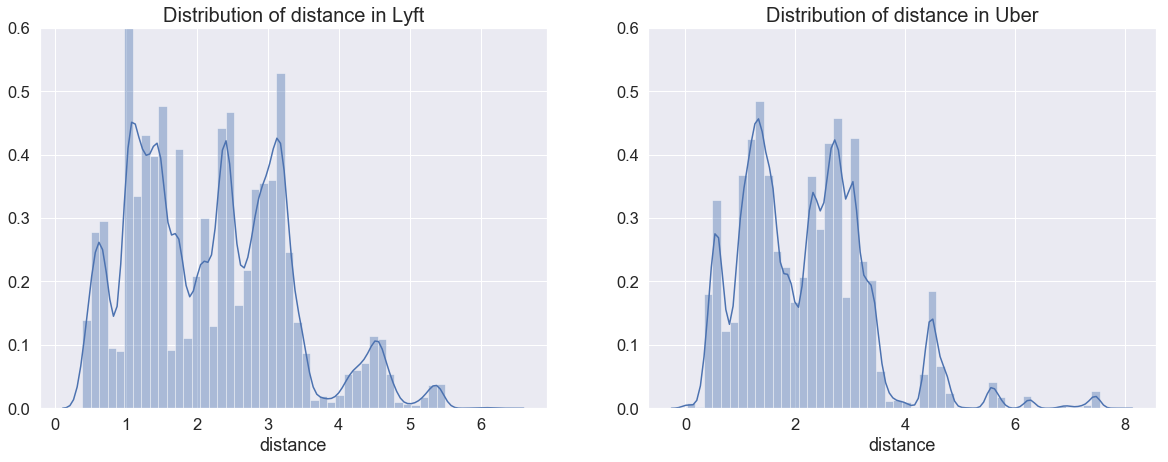

In [1772]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.distplot(lyft['distance'], ax=ax1, kde=True)
ax1.set_title('Distribution of distance in Lyft', fontsize=20)
ax1.set_ylim(0, 0.6)
a = sns.distplot(uber['distance'], ax=ax2)
ax2.set_title('Distribution of distance in Uber', fontsize=20)
ax2.set_ylim(0, 0.6)

In [1773]:
# a.figure.savefig(r'C:\Users\gokul\Downloads\distance.jpg')

Text(0.5, 1.0, 'Uber')

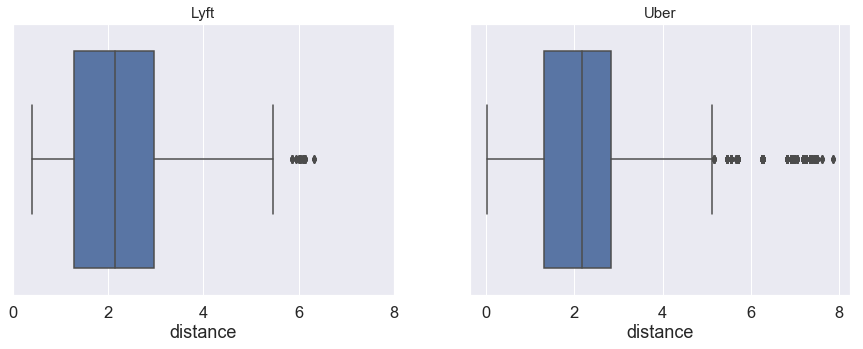

In [1774]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(lyft['distance'], ax=ax1)
ax1.set_title('Lyft', fontsize=15)
ax1.set_xlim(0, 8)
sns.boxplot(uber['distance'], ax=ax2)
ax2.set_title('Uber', fontsize=15)

In [1775]:
# lyft[lyft['distance']<0.3] # can we remove records below 0.3 as cancellation records

In [1776]:
# uber[uber['distance']<0.25].sort_values(by='distance', ascending=False).head(30)

From the above graphs, we can see that most of the rides are in the range of approximately 0.5 to 5.5 miles. 
The distribution is slightly right skewed in the both Lyft and Uber.
Distance in Lyft is more dispersed than Uber.           
Both the data contains outliers, due to certain weather conditions riders have to travel extra distance than usual,
and occassionally riders tend to travel long distances.

**Price (Target variable)**

In [1777]:
overall = cab_data['price'].describe()
overall # measure of central tendency

count    637976.000000
mean         16.545125
std           9.324359
min           2.500000
25%           9.000000
50%          13.500000
75%          22.500000
max          97.500000
Name: price, dtype: float64

In [1778]:
uber_price = uber['price'].describe()
uber_price

count    330568.000000
mean         15.795343
std           8.560300
min           4.500000
25%           9.000000
50%          12.500000
75%          21.500000
max          89.500000
Name: price, dtype: float64

In [1779]:
lyft[lyft.price<2.9].shape

(211, 11)

In [1780]:
lyft_price = lyft['price'].describe()
lyft_price

count    307408.000000
mean         17.351396
std          10.019171
min           2.500000
25%           9.000000
50%          16.500000
75%          22.500000
max          97.500000
Name: price, dtype: float64

In [1781]:
uber.price.sum(), lyft.price.sum()

(5221435.0, 5333957.979999999)

In [1782]:
df = pd.DataFrame({'Overall': overall.values,
                  'Lyft': lyft_price.values,
                  'Uber': uber_price.values}, index= ['Count', 'Mean', 'Std. Dev.', 'Min', '25%', '50%', '75%', 'Max'])
df

,Overall,Lyft,Uber
Count,637976.000000,307408.000000,330568.000000
Mean,16.545125,17.351396,15.795343
Std. Dev.,9.324359,10.019171,8.560300
Min,2.500000,2.500000,4.500000
25%,9.000000,9.000000,9.000000
50%,13.500000,16.500000,12.500000
75%,22.500000,22.500000,21.500000
Max,97.500000,97.500000,89.500000


In [1783]:
# df.to_csv(r'C:\Users\gokul\Downloads\metrics.csv')

In [1784]:
calculate_mop(Lyft= lyft['price'], Uber= uber['price']) # measure of dispersion

Lyft 

Standard deviation:     10.019170761821647
Skewness:               0.9779622794919607
Kurtosis:               1.4373703138968161

Uber 

Standard deviation:     8.560299982017439
Skewness:               1.0528694623412944
Kurtosis:               0.44005424456108555



Text(0.5, 1.0, 'Distribution of price in Uber')

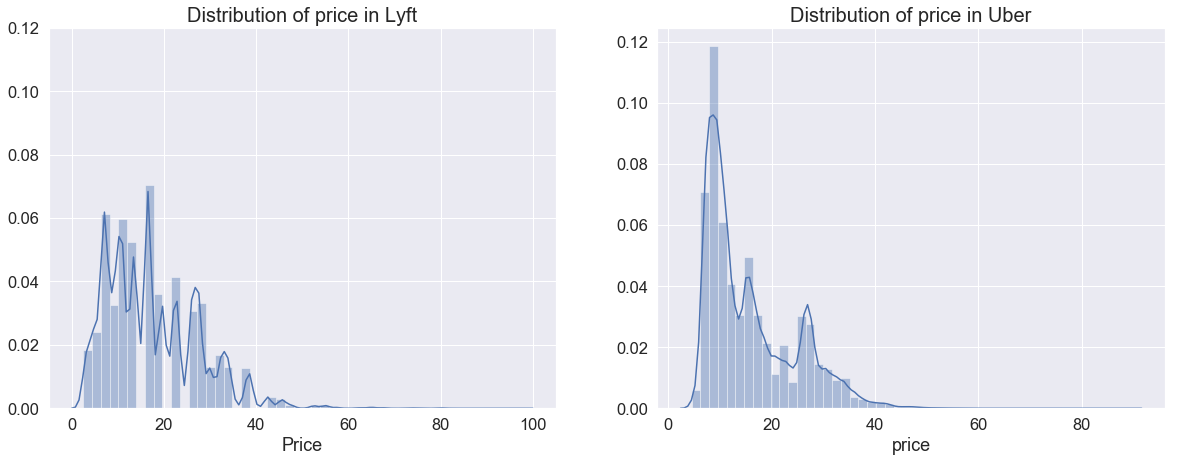

In [1785]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
a = sns.distplot(lyft['price'], ax=ax1)
ax1.set_title('Distribution of price in Lyft', fontsize=20)
ax1.set(xlabel='Price')
ax1.set_ylim(0, 0.12)
b =sns.distplot(uber[~uber['price'].isnull()]['price'], ax=ax2)
ax2.set_title('Distribution of price in Uber', fontsize=20)

In [1786]:
# a.figure.savefig(r'C:\Users\gokul\Downloads\price.jpg')

(0, 100)

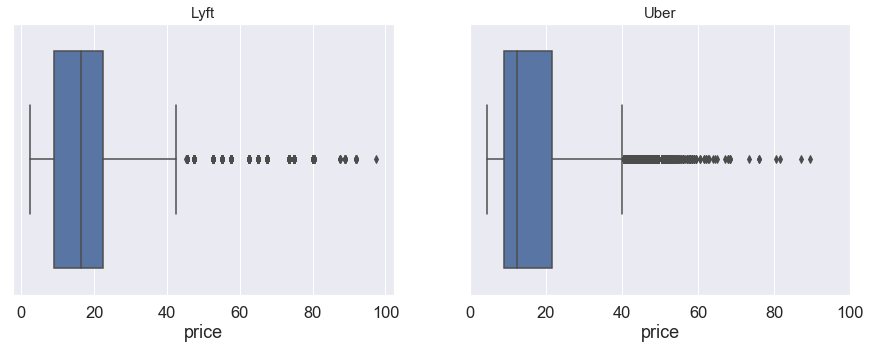

In [1787]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(lyft['price'], ax=ax1)
ax1.set_title('Lyft', fontsize=15)

sns.boxplot(uber[~uber['price'].isnull()]['price'], ax=ax2)
ax2.set_title('Uber', fontsize=15)
ax2.set_xlim(0, 100)

**Outliers**       
These outliers are due to use of high-end cars and high surge multipliers. So, we decided to keep it.

In [1788]:
lyft[(lyft['price']>40)].head(3)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
469,2.93,Lyft,Theatre District,Boston University,42.5,1.25,fa6e092f-5562-49ef-916c-92d8148111ee,lyft_luxsuv,Lux Black XL,2018-12-02,21
639,3.80,Lyft,Fenway,Financial District,42.5,1.00,4c1f503c-2411-4c59-b416-c9831f3da44b,lyft_luxsuv,Lux Black XL,2018-11-27,12
705,3.25,Lyft,Back Bay,South Station,42.5,2.50,46c02b41-6f51-43ab-a389-21d704cac2db,lyft_plus,Lyft XL,2018-12-02,7


In [1789]:
uber[(uber['price']>40)].head(3)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
595,4.42,Uber,Financial District,Fenway,41.0,1.0,64938ba3-cd07-4080-9ee9-ea78f1df0f11,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-12-16,17
1981,5.56,Uber,Boston University,Financial District,40.5,1.0,dcf399d5-d80e-49c4-8675-c3da0b828729,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-12-03,16
2104,4.48,Uber,Fenway,Financial District,42.0,1.0,d0e9ef6f-a268-411b-a41c-c7eb2fea3210,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-27,5


In [1790]:
# a = uber[uber['price']<40].groupby(by=['source', 'destination']).median()#.head(10)
# a

In [1791]:
# a.to_csv(r'C:\Users\gokul\Downloads\tab.csv')

In [1792]:
uber[uber['price']>40].groupby(by=['source', 'destination']).mean().head(10)

distance      price  surge_multiplier  \
source      destination                                                      
Back Bay    Boston University        1.410000  43.250000               1.0   
            Fenway                   1.386667  44.166667               1.0   
            Haymarket Square         4.895556  46.888889               1.0   
            North End                6.117143  48.452381               1.0   
            Northeastern University  1.160000  44.500000               1.0   
            South Station            6.124224  44.118012               1.0   
Beacon Hill Boston University        2.270000  54.500000               1.0   
            Fenway                   2.290000  48.000000               1.0   
            North End                2.356667  45.666667               1.0   
            Northeastern University  2.407500  51.875000               1.0   

                                          hour  
source      destination                         
Back Bay    Boston University        23.000000  
            Fenway                   15.333333  
            Haymarket Square         11.222222  
            North End                17.523810  
            Northeastern University  11.500000  
            South Station            17.751553  
Beacon Hill Boston University         4.000000  
            Fenway                    0.000000  
            North End                 5.666667  
            Northeastern University   6.750000

**Outliers handling**      
We could see that, some rides higher price than usual for different car models. From our analysis, we came to know,
duration of the trip also has impact on the price, and we do not posses data regarding the
duration of the trip, so we cannot remove these outliers.

The price distribution is right skewed, from the boxplot we could see the outliers present in the data.         
On average, the price range varies from 5 to 40 US dollars,           
Presence of outliers is due to factors such as use of luxury or premium cars for rides, travelling in high traffic city 
and bad weather conditions.

**Categorical variables**

**Cab type**

In [1793]:
cab_data['cab_type'].value_counts() # frequency count

Uber    385663
Lyft    307408
Name: cab_type, dtype: int64

In [1794]:
cab_data['cab_type'].value_counts(normalize=True) # percentage of values

Uber    0.556455
Lyft    0.443545
Name: cab_type, dtype: float64

Text(0.5, 1.0, 'Frequency of Uber and Lyft data')

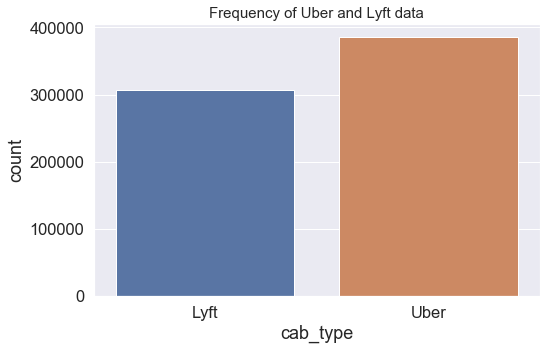

In [1795]:
plt.figure(figsize=(8,5))
sns.countplot('cab_type', data=cab_data)
plt.title('Frequency of Uber and Lyft data', fontsize=15)

The dataset contains relatively high proportion of Uber data, with both having records more than 300,000 data points.

**Car model**

In [1796]:
lyft['name'].value_counts() # frequency count

Lyft            51235
Lux Black       51235
Lux             51235
Lux Black XL    51235
Lyft XL         51235
Shared          51233
Name: name, dtype: int64

In [1797]:
uber['name'].value_counts()

WAV          55096
UberXL       55096
Black SUV    55096
Taxi         55095
Black        55095
UberX        55094
UberPool     55091
Name: name, dtype: int64

Text(0.5, 1.0, 'Frequency count of car models  in Uber')

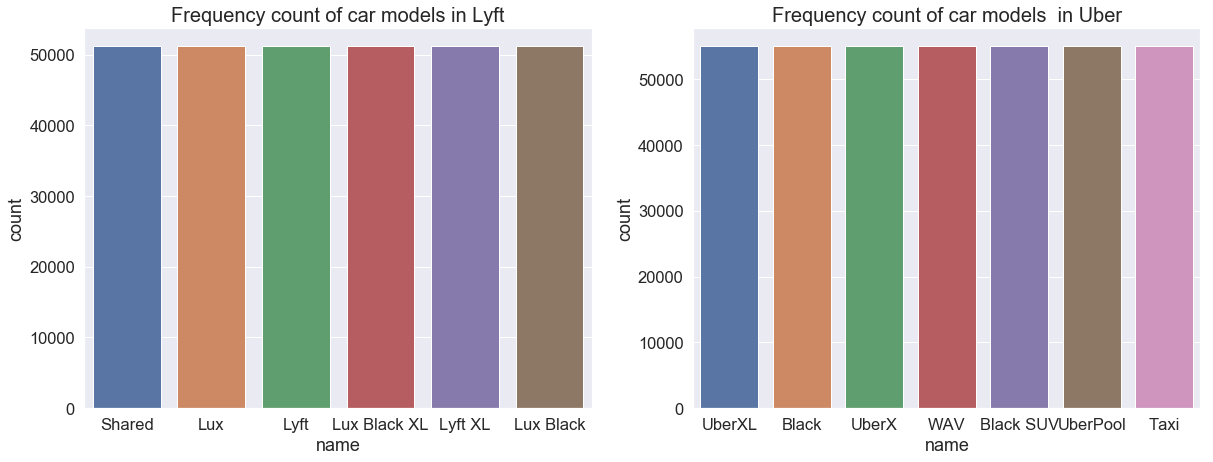

In [1798]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.countplot(lyft['name'], ax=ax1)
ax1.set_title('Frequency count of car models in Lyft', fontsize=20)
sns.countplot(uber['name'], ax=ax2)
ax2.set_title('Frequency count of car models  in Uber', fontsize=20)

From the frequency plot, we could almost all the car models are used in similar frequency.

**Source**

In [1799]:
lyft['source'].value_counts() # frequency count

Financial District         26237
Back Bay                   25655
South Station              25620
Fenway                     25620
North End                  25620
Boston University          25620
Northeastern University    25614
Haymarket Square           25614
Theatre District           25530
West End                   25488
Beacon Hill                25464
North Station              25326
Name: source, dtype: int64

In [1800]:
uber['source'].value_counts()

Financial District         32620
Theatre District           32283
Boston University          32144
North End                  32143
Northeastern University    32142
Fenway                     32137
Back Bay                   32137
South Station              32130
Haymarket Square           32122
West End                   32074
Beacon Hill                31939
North Station              31792
Name: source, dtype: int64

[Text(0, 0, 'North End'),
 Text(0, 0, 'Beacon Hill'),
 Text(0, 0, 'North Station'),
 Text(0, 0, 'Boston University'),
 Text(0, 0, 'South Station'),
 Text(0, 0, 'Fenway'),
 Text(0, 0, 'Theatre District'),
 Text(0, 0, 'West End'),
 Text(0, 0, 'Back Bay'),
 Text(0, 0, 'Northeastern University'),
 Text(0, 0, 'Haymarket Square'),
 Text(0, 0, 'Financial District')]

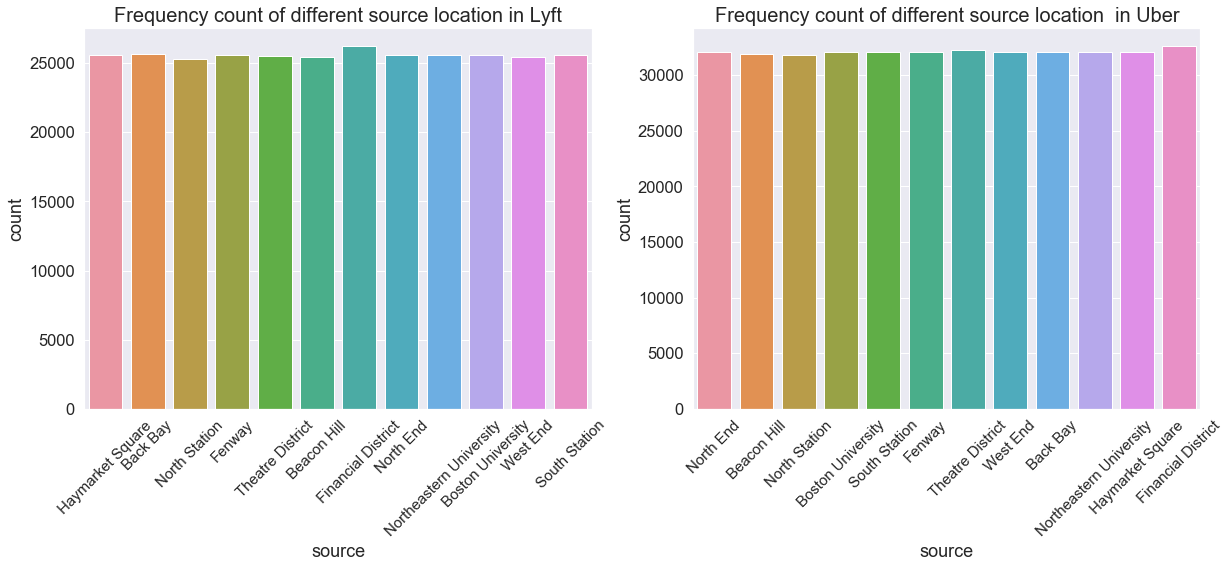

In [1801]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.countplot(lyft['source'], ax=ax1)
ax1.set_title('Frequency count of different source location in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=15)
# ax1.set_ylim(0, 25000)
sns.countplot(uber['source'], ax=ax2)
ax2.set_title('Frequency count of different source location  in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=15)

**Destination**

In [1802]:
lyft['destination'].value_counts()

Financial District         26238
Back Bay                   25650
South Station              25620
Fenway                     25620
Northeastern University    25619
North End                  25614
Boston University          25614
Haymarket Square           25613
Theatre District           25536
West End                   25494
Beacon Hill                25464
North Station              25326
Name: destination, dtype: int64

In [1803]:
uber['destination'].value_counts()

Financial District         32613
Theatre District           32262
Haymarket Square           32151
Boston University          32150
North End                  32142
Fenway                     32137
Northeastern University    32136
Back Bay                   32130
South Station              32129
West End                   32081
Beacon Hill                31939
North Station              31793
Name: destination, dtype: int64

[Text(0, 0, 'West End'),
 Text(0, 0, 'South Station'),
 Text(0, 0, 'Fenway'),
 Text(0, 0, 'Beacon Hill'),
 Text(0, 0, 'North Station'),
 Text(0, 0, 'Back Bay'),
 Text(0, 0, 'North End'),
 Text(0, 0, 'Northeastern University'),
 Text(0, 0, 'Financial District'),
 Text(0, 0, 'Theatre District'),
 Text(0, 0, 'Boston University'),
 Text(0, 0, 'Haymarket Square')]

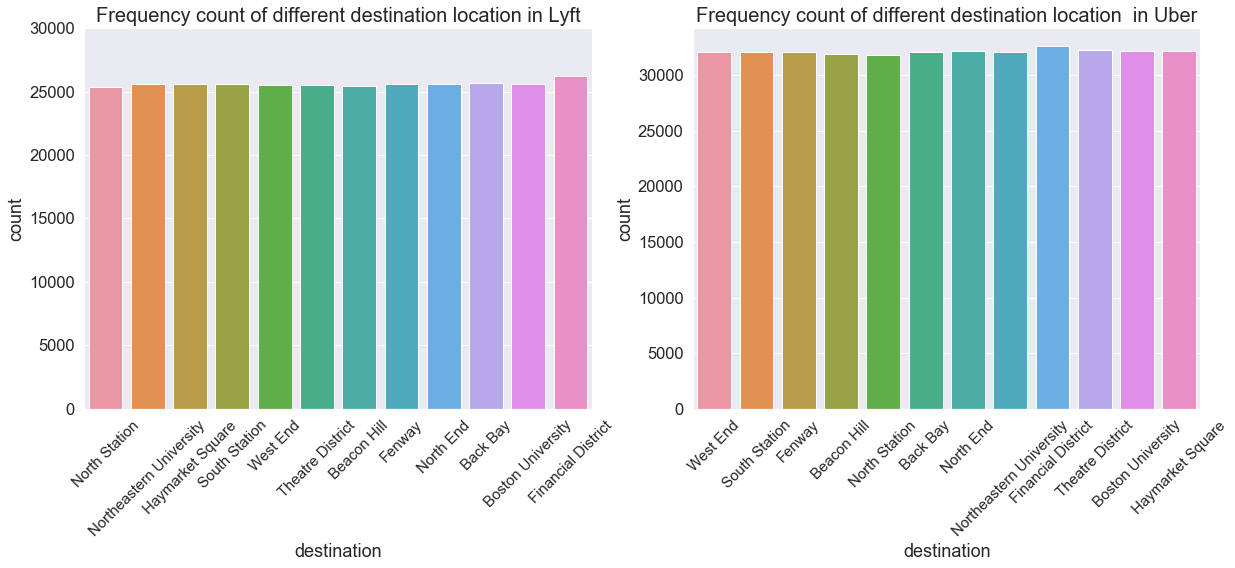

In [1804]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.countplot(lyft['destination'], ax=ax1)
ax1.set_title('Frequency count of different destination location in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=15)
ax1.set_ylim(0, 30000)
sns.countplot(uber['destination'], ax=ax2)
ax2.set_title('Frequency count of different destination location  in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=15)

**Product Id**

In [1805]:
lyft['product_id'].value_counts()

lyft_luxsuv     51235
lyft_lux        51235
lyft_premier    51235
lyft            51235
lyft_plus       51235
lyft_line       51233
Name: product_id, dtype: int64

In [1806]:
uber['product_id'].value_counts()

6d318bcc-22a3-4af6-bddd-b409bfce1546    55096
6f72dfc5-27f1-42e8-84db-ccc7a75f6969    55096
9a0e7b09-b92b-4c41-9779-2ad22b4d779d    55096
6c84fd89-3f11-4782-9b50-97c468b19529    55095
8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a    55095
55c66225-fbe7-4fd5-9072-eab1ece5e23e    55094
997acbb5-e102-41e1-b155-9df7de0a73f2    55091
Name: product_id, dtype: int64

[Text(0, 0, '6f72dfc5-27f1-42e8-84db-ccc7a75f6969'),
 Text(0, 0, '6c84fd89-3f11-4782-9b50-97c468b19529'),
 Text(0, 0, '55c66225-fbe7-4fd5-9072-eab1ece5e23e'),
 Text(0, 0, '9a0e7b09-b92b-4c41-9779-2ad22b4d779d'),
 Text(0, 0, '6d318bcc-22a3-4af6-bddd-b409bfce1546'),
 Text(0, 0, '997acbb5-e102-41e1-b155-9df7de0a73f2'),
 Text(0, 0, '8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a')]

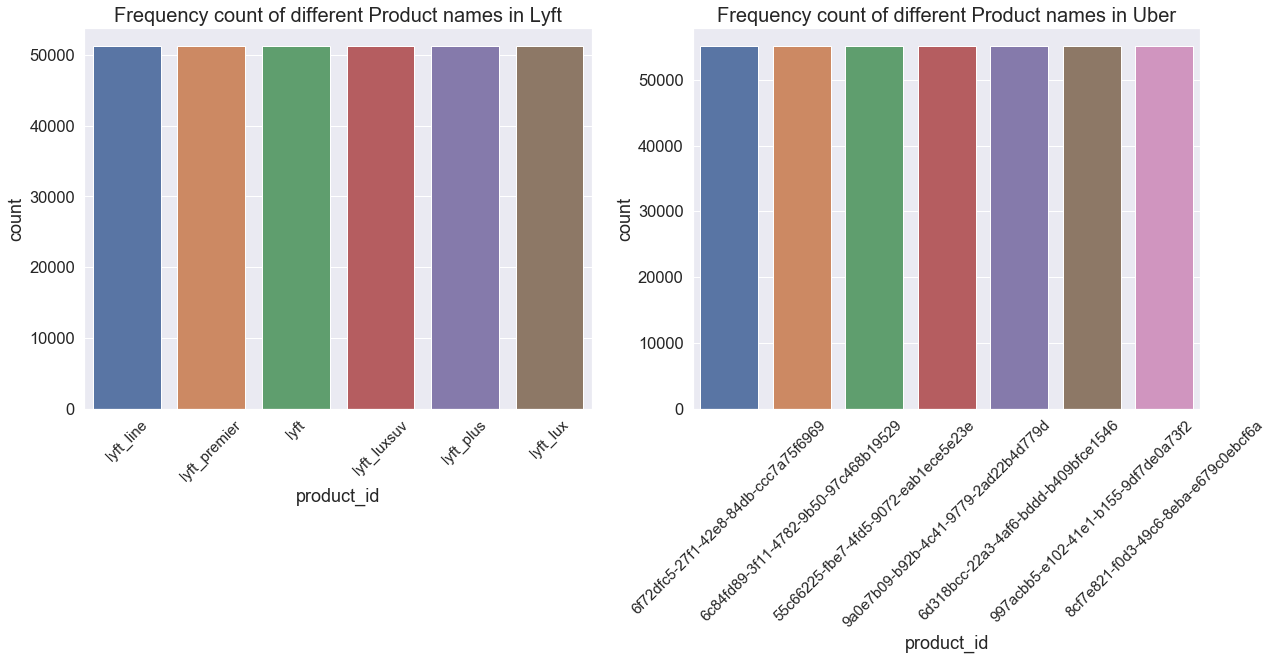

In [1807]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.countplot(lyft['product_id'], ax=ax1)
ax1.set_title('Frequency count of different Product names in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=15)
sns.countplot(uber['product_id'], ax=ax2)
ax2.set_title('Frequency count of different Product names in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=15)

**Surge multiplier**

In [1808]:
lyft['surge_multiplier'].value_counts() # frequency count

1.00    286433
1.25     11085
1.50      5065
1.75      2420
2.00      2239
2.50       154
3.00        12
Name: surge_multiplier, dtype: int64

In [1809]:
uber['surge_multiplier'].value_counts()

1.0    385663
Name: surge_multiplier, dtype: int64

(0, 350000)

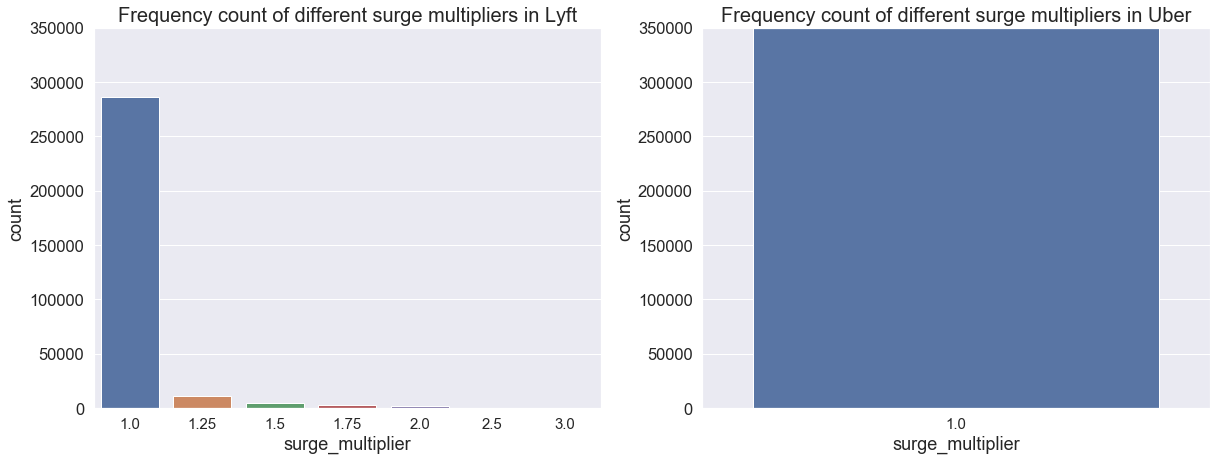

In [1810]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.countplot(lyft['surge_multiplier'], ax=ax1)
ax1.set_title('Frequency count of different surge multipliers in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=15)
ax1.set_ylim(0, 350000)
sns.countplot(uber['surge_multiplier'], ax=ax2)
ax2.set_title('Frequency count of different surge multipliers in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=15)
ax2.set_ylim(0, 350000)

From the above charts, we see that, there is a variety of surge mulipliers in Lyft, whereas in Uber, there is only one 
surge multiplier.     
This has increased the number of riders in Uber, compared to Lyft.

**Hour**

In [1811]:
lyft['hour'].value_counts()

0     14976
23    14760
10    13248
16    13248
12    13248
13    13248
14    13248
11    13248
17    13248
18    13248
15    13247
2     13176
1     13176
22    12888
4     12888
3     12786
9     12600
21    12024
19    11952
6     11880
20    11592
5     11232
7     11160
8     11087
Name: hour, dtype: int64

In [1812]:
uber['hour'].value_counts()

0     17437
23    17171
10    17136
15    17136
12    17136
13    17136
14    17136
11    17136
16    17136
17    17136
18    17136
22    16548
9     16371
21    15708
19    15603
6     15456
4     15442
2     15372
1     15372
20    15190
3     15029
7     13776
5     13776
8     13188
Name: hour, dtype: int64

(0, 17500)

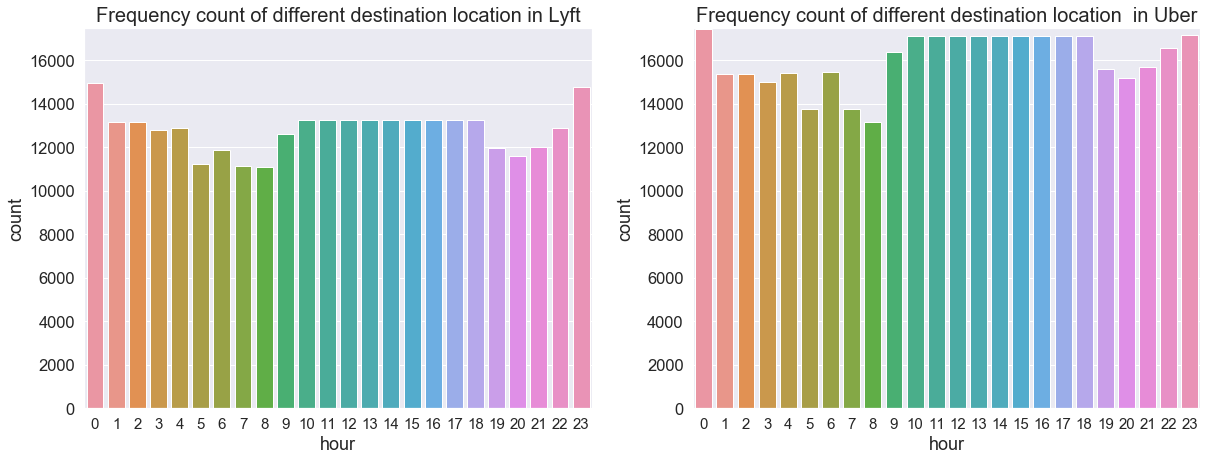

In [1813]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.countplot(lyft['hour'], ax=ax1)
ax1.set_title('Frequency count of different destination location in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=15)
ax1.set_ylim(0, 17500)
sns.countplot(uber['hour'], ax=ax2)
ax2.set_title('Frequency count of different destination location  in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=15)
ax2.set_ylim(0, 17500)

Hour has almost similar distribution for both Uber and Lyft.  This is due to fact that cab riders has the option to choose
between Lyft and Uber for their customers.       
We can see that there is high usage in the hours from 10 to evening 7, this makes sense as this the office hours,
where people likely to travel frequently.

## Bi-variate Analysis

### Continuous & Continuous

(0, 100)

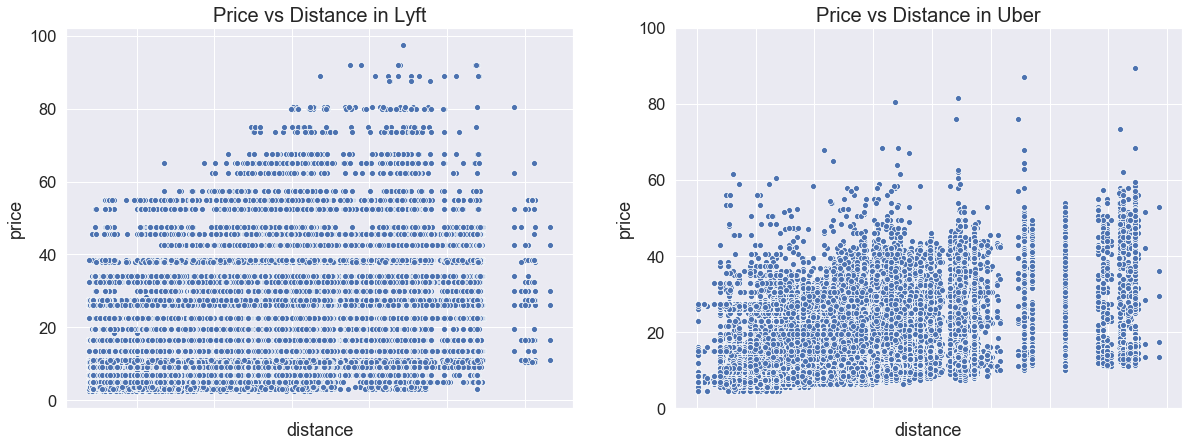

In [1814]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.scatterplot(lyft['distance'], lyft['price'], ax=ax1)
ax1.set_title('Price vs Distance in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=15)
sns.scatterplot(uber['distance'], uber['price'], ax=ax2)
ax2.set_title('Price vs Distance in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=15)
ax2.set_ylim(0, 100)

In [1815]:
lyft['distance'].corr(lyft['price'])

0.3615666155487001

In [1816]:
uber['distance'].corr(uber['price'])

0.3362037661660918

Distance is one of the important factors, which drives the price of the rides.  We could see that there is a positive 
correlation in the graph, with the presence of outliers as we saw before, because of the use of luxury car models and 
bad weather conditions.

### Categorical & Categorical:

**Cab type vs Source**

In [1817]:
a= pd.crosstab(cab_data['cab_type'], cab_data['source'])
a

source,Back Bay,Beacon Hill,Boston University,Fenway,Financial District,Haymarket Square,North End,North Station,Northeastern University,South Station,Theatre District,West End
cab_type,,,,,,,,,,,,
Lyft,25655,25464,25620,25620,26237,25614,25620,25326,25614,25620,25530,25488
Uber,32137,31939,32144,32137,32620,32122,32143,31792,32142,32130,32283,32074


In [1818]:
pd.crosstab(cab_data['cab_type'], cab_data['source'], normalize=True)

source,Back Bay,Beacon Hill,Boston University,Fenway,Financial District,Haymarket Square,North End,North Station,Northeastern University,South Station,Theatre District,West End
cab_type,,,,,,,,,,,,
Lyft,0.037016,0.036741,0.036966,0.036966,0.037856,0.036957,0.036966,0.036542,0.036957,0.036966,0.036836,0.036775
Uber,0.046369,0.046083,0.046379,0.046369,0.047066,0.046347,0.046378,0.045871,0.046376,0.046359,0.046580,0.046278


<Figure size 720x504 with 0 Axes>

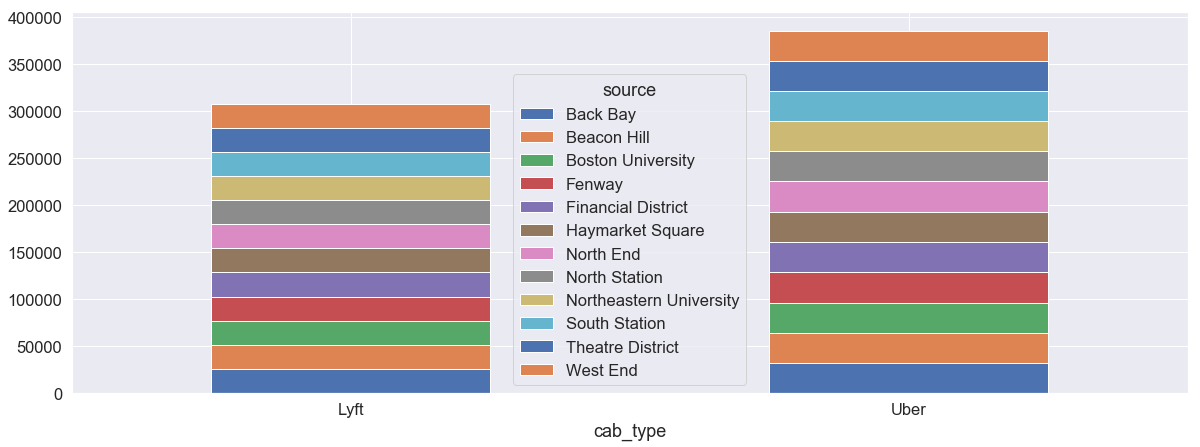

In [1819]:
plt.figure(figsize=(10,7))
pd.crosstab(cab_data['cab_type'], cab_data['source']).plot.bar(stacked=True, figsize=(20,7), rot=0)

**Cab type vs Destination**

In [1820]:
pd.crosstab(cab_data['cab_type'], cab_data['destination'])

destination,Back Bay,Beacon Hill,Boston University,Fenway,Financial District,Haymarket Square,North End,North Station,Northeastern University,South Station,Theatre District,West End
cab_type,,,,,,,,,,,,
Lyft,25650,25464,25614,25620,26238,25613,25614,25326,25619,25620,25536,25494
Uber,32130,31939,32150,32137,32613,32151,32142,31793,32136,32129,32262,32081


In [1821]:
pd.crosstab(cab_data['cab_type'], cab_data['destination'], normalize=True)

destination,Back Bay,Beacon Hill,Boston University,Fenway,Financial District,Haymarket Square,North End,North Station,Northeastern University,South Station,Theatre District,West End
cab_type,,,,,,,,,,,,
Lyft,0.037009,0.036741,0.036957,0.036966,0.037858,0.036956,0.036957,0.036542,0.036964,0.036966,0.036845,0.036784
Uber,0.046359,0.046083,0.046388,0.046369,0.047056,0.046389,0.046376,0.045873,0.046368,0.046357,0.046549,0.046288


<Figure size 720x504 with 0 Axes>

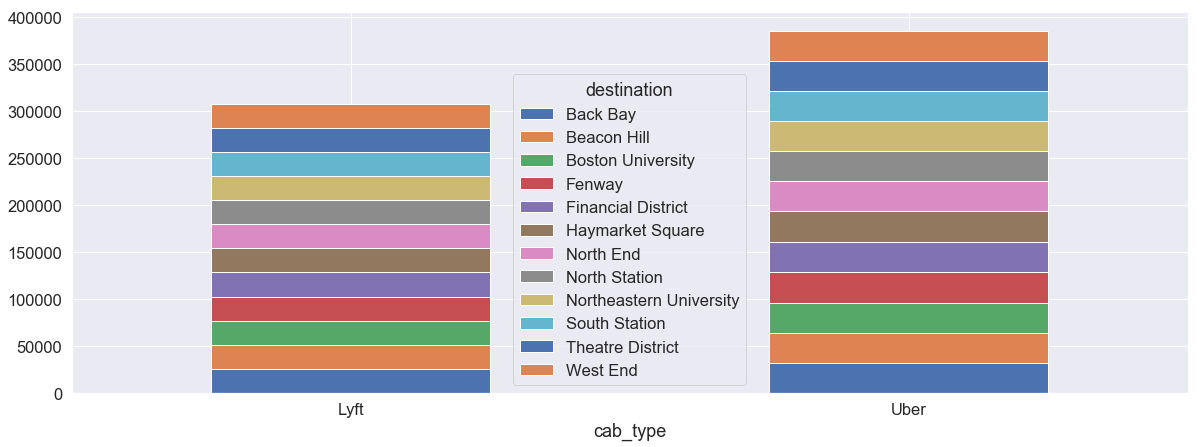

In [1822]:
plt.figure(figsize=(10,7))
pd.crosstab(cab_data['cab_type'], cab_data['destination']).plot.bar(stacked=True, figsize=(20,7), rot=0)

**Cab type vs Surge multiplier**

In [1823]:
pd.crosstab(cab_data['cab_type'], cab_data['surge_multiplier'])

surge_multiplier,1.00,1.25,1.50,1.75,2.00,2.50,3.00
cab_type,,,,,,,
Lyft,286433,11085,5065,2420,2239,154,12
Uber,385663,0,0,0,0,0,0


In [1824]:
pd.crosstab(cab_data['cab_type'], cab_data['surge_multiplier'], normalize=True)

surge_multiplier,1.00,1.25,1.50,1.75,2.00,2.50,3.00
cab_type,,,,,,,
Lyft,0.413281,0.015994,0.007308,0.003492,0.003231,0.000222,0.000017
Uber,0.556455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<Figure size 720x504 with 0 Axes>

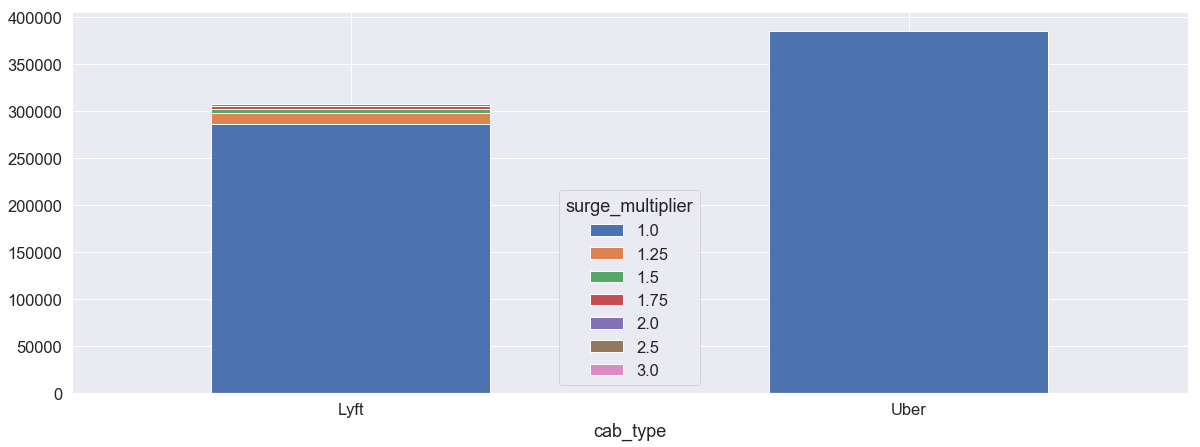

In [1825]:
plt.figure(figsize=(10,7))
pd.crosstab(cab_data['cab_type'], cab_data['surge_multiplier']).plot.bar(stacked=True, figsize=(20,7), rot=0)

**Car model vs Source**

In [1826]:
pd.crosstab(lyft['name'], lyft['source'])

source,Back Bay,Beacon Hill,Boston University,Fenway,Financial District,Haymarket Square,North End,North Station,Northeastern University,South Station,Theatre District,West End
name,,,,,,,,,,,,
Lux,4276,4244,4270,4270,4373,4269,4270,4221,4269,4270,4255,4248
Lux Black,4276,4244,4270,4270,4373,4269,4270,4221,4269,4270,4255,4248
Lux Black XL,4276,4244,4270,4270,4373,4269,4270,4221,4269,4270,4255,4248
Lyft,4276,4244,4270,4270,4373,4269,4270,4221,4269,4270,4255,4248
Lyft XL,4276,4244,4270,4270,4373,4269,4270,4221,4269,4270,4255,4248
Shared,4275,4244,4270,4270,4372,4269,4270,4221,4269,4270,4255,4248


<Figure size 720x504 with 0 Axes>

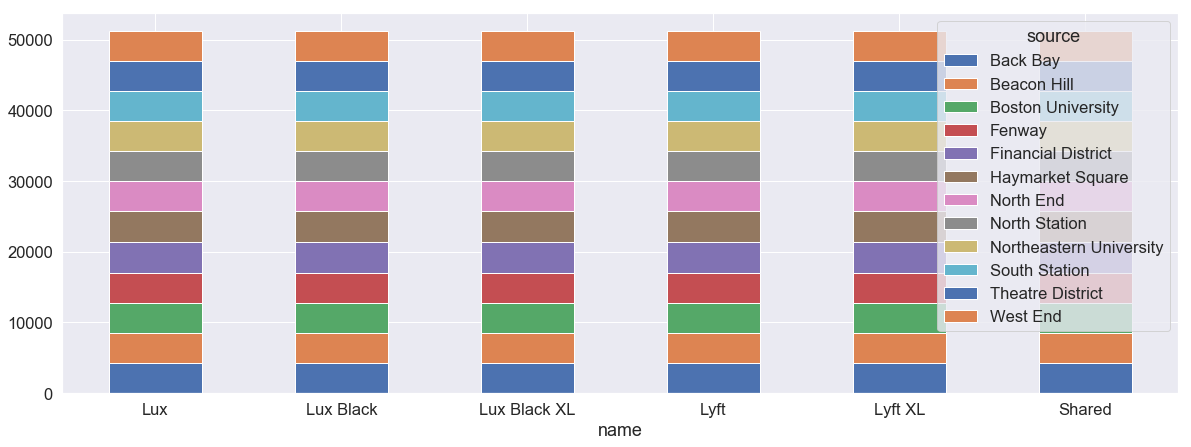

In [1827]:
plt.figure(figsize=(10,7))
pd.crosstab(lyft['name'], lyft['source']).plot.bar(stacked=True, figsize=(20,7), rot=0)

In [1828]:
cab_data['source'].nunique(), cab_data['destination'].nunique()

(12, 12)

In [1829]:
pd.crosstab(uber['name'], uber['source'])

source,Back Bay,Beacon Hill,Boston University,Fenway,Financial District,Haymarket Square,North End,North Station,Northeastern University,South Station,Theatre District,West End
name,,,,,,,,,,,,
Black,4591,4563,4592,4591,4660,4589,4591,4542,4592,4590,4612,4582
Black SUV,4591,4563,4592,4591,4660,4589,4592,4542,4592,4590,4612,4582
Taxi,4591,4562,4592,4591,4660,4589,4592,4542,4592,4590,4612,4582
UberPool,4591,4562,4592,4591,4660,4588,4592,4541,4591,4590,4611,4582
UberX,4591,4563,4592,4591,4660,4589,4592,4541,4591,4590,4612,4582
UberXL,4591,4563,4592,4591,4660,4589,4592,4542,4592,4590,4612,4582
WAV,4591,4563,4592,4591,4660,4589,4592,4542,4592,4590,4612,4582


**Car model vs Surge multiplier**

In [1830]:
pd.crosstab(lyft['name'], lyft['surge_multiplier'])

surge_multiplier,1.00,1.25,1.50,1.75,2.00,2.50,3.00
name,,,,,,,
Lux,47040,2217,1013,484,481,0,0
Lux Black,47040,2217,1013,484,481,0,0
Lux Black XL,47040,2217,1013,484,481,0,0
Lyft,47040,2217,1013,484,398,77,6
Lyft XL,47040,2217,1013,484,398,77,6
Shared,51233,0,0,0,0,0,0


We can see that, the surge multiplier doesn't vary for different car models in Lyft, except for few exceptions
in Lyft XL, which is a high-end car services of Lyft.

In [1831]:
pd.crosstab(lyft['name'], lyft['surge_multiplier'], normalize=True)

surge_multiplier,1.00,1.25,1.50,1.75,2.00,2.50,3.00
name,,,,,,,
Lux,0.153021,0.007212,0.003295,0.001574,0.001565,0.00000,0.00000
Lux Black,0.153021,0.007212,0.003295,0.001574,0.001565,0.00000,0.00000
Lux Black XL,0.153021,0.007212,0.003295,0.001574,0.001565,0.00000,0.00000
Lyft,0.153021,0.007212,0.003295,0.001574,0.001295,0.00025,0.00002
Lyft XL,0.153021,0.007212,0.003295,0.001574,0.001295,0.00025,0.00002
Shared,0.166661,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000


<Figure size 720x504 with 0 Axes>

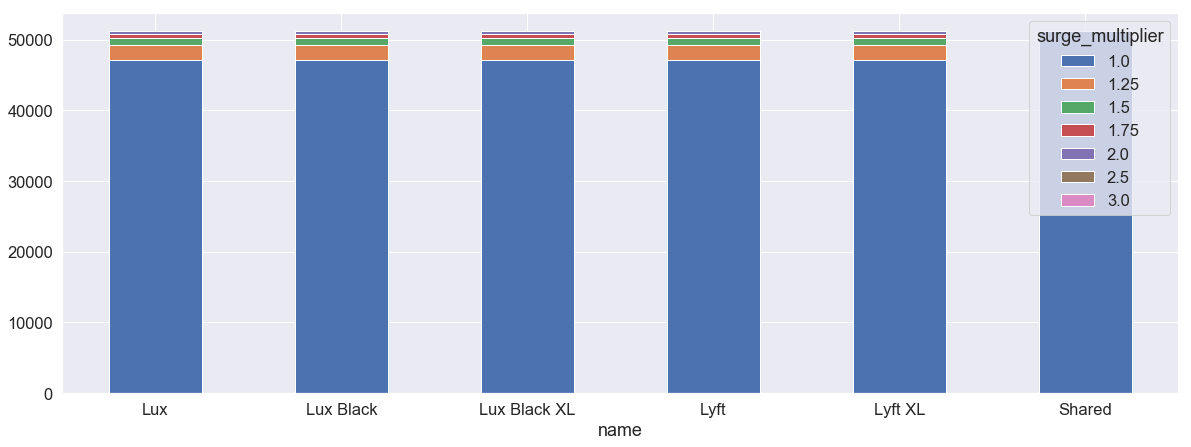

In [1832]:
plt.figure(figsize=(10,7))
pd.crosstab(lyft['name'], lyft['surge_multiplier']).plot.bar(stacked=True, figsize=(20,7), rot=0)

In [1833]:
pd.crosstab(uber['name'], uber['surge_multiplier'])

surge_multiplier,1.0
name,
Black,55095
Black SUV,55096
Taxi,55095
UberPool,55091
UberX,55094
UberXL,55096
WAV,55096


**Source vs Destination**

In [1834]:
pd.crosstab(uber['source'], uber['destination'])

destination,Back Bay,Beacon Hill,Boston University,Fenway,Financial District,Haymarket Square,North End,North Station,Northeastern University,South Station,Theatre District,West End
source,,,,,,,,,,,,
Back Bay,0,0,5271,5257,0,5369,5677,0,5313,5250,0,0
Beacon Hill,0,0,5124,5236,0,5348,5593,0,5382,5256,0,0
Boston University,5271,5117,0,0,5397,0,0,5250,0,0,5551,5558
Fenway,5264,5236,0,0,5355,0,0,5467,0,0,5180,5635
Financial District,0,0,5397,5369,0,5628,5187,0,5313,5726,0,0
Haymarket Square,5369,5348,0,0,5628,0,0,5320,0,0,5333,5124
North End,5677,5593,0,0,5187,0,0,5228,0,0,5355,5103
North Station,0,0,5250,5467,0,5327,5227,0,5425,5096,0,0
Northeastern University,5313,5388,0,0,5320,0,0,5425,0,0,5390,5306


This table shows that, we cannot hope to go to any place within Boston city, 
As we can see that, these destinations are within 3 miles from source. Are people in Massachussettes, choose to skip cabs 
within 3 miles, we need to analyze further to make any claims.

## Weather dataset

In [1835]:
weather_data.info() # basic info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
temp          6276 non-null float64
location      6276 non-null object
clouds        6276 non-null float64
pressure      6276 non-null float64
rain          894 non-null float64
time_stamp    6276 non-null int64
humidity      6276 non-null float64
wind          6276 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


**Attribute Information**

Location - Location name              
Clouds              
Pressure - pressure in mb              
Rain - rain in inches for the last hr              
Time_stamp - epoch time when row data was collected              
Humidity - humidity in %              
Wind - wind speed in mph

### Data Type      
**Object**

    - location
    
**Numeric**       
    - temp
    - clouds
    - pressure
    - rain
    - time stamp
    - humidity
    - wind

### Feature category        
**Categorical**       
    - location
    
**Continuous**     
    - temp
    - time stamp
    - clouds
    - pressure
    - rain
    - humidity
    - wind

### Univariate Analysis

In [1836]:
# let's impute the unix epoch time to standard date time format
weather_data['time_stamp'] = pd.to_datetime(weather_data['time_stamp'], unit='s')
weather_data['date'] = weather_data['time_stamp'].dt.date
weather_data['hour'] = weather_data['time_stamp'].dt.hour

weather_data.drop('time_stamp', axis=1, inplace=True)

weather_data.head(3)

,temp,location,clouds,pressure,rain,humidity,wind,date,hour
0,42.42,Back Bay,1.0,1012.14,0.1228,0.77,11.25,2018-12-16,23
1,42.43,Beacon Hill,1.0,1012.15,0.1846,0.76,11.32,2018-12-16,23
2,42.50,Boston University,1.0,1012.15,0.1089,0.76,11.07,2018-12-16,23


**Continuous**

**Temperature**

In [1837]:
weather_data['temp'].describe()

count    6276.000000
mean       39.090475
std         6.022055
min        19.620000
25%        36.077500
50%        40.130000
75%        42.832500
max        55.410000
Name: temp, dtype: float64

In [1838]:
calculate_mop(Temperature = weather_data['temp'])

Temperature 

Standard deviation:     6.0220551532287905
Skewness:               -0.6367774660732213
Kurtosis:               0.9473947101070599



Text(0.5, 1.0, 'Distribution of Temperature')

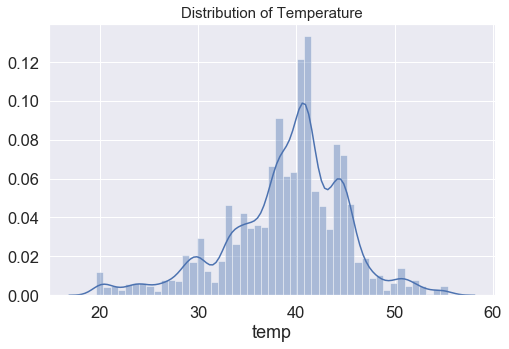

In [1839]:
plt.figure(figsize=(8,5))
sns.distplot(weather_data['temp'])
plt.title('Distribution of Temperature', fontsize=15)

Text(0.5, 1.0, 'Distribution of Temperature')

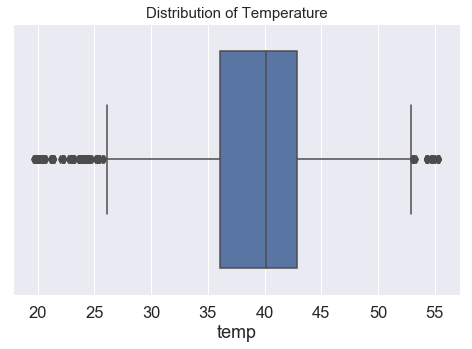

In [1840]:
plt.figure(figsize=(8,5))
sns.boxplot(weather_data['temp'])
plt.title('Distribution of Temperature', fontsize=15)

In [1841]:
weather_data[weather_data.temp < 26].date.value_counts()

2018-12-13    171
2018-12-18     48
Name: date, dtype: int64

In [1842]:
weather_data[weather_data.temp > 53].date.value_counts()

2018-12-03    43
Name: date, dtype: int64

According to this website https://www.timeanddate.com/weather/usa/boston/historic?month=12&year=2018,
the data is legitimate. We can keep the outliers.

In [1843]:
weather_data[weather_data['temp']<27].shape

(263, 9)

In [1844]:
weather_data[weather_data['temp']>52.5].shape

(60, 9)

Temperature is slighty left skewed, and it makes sense, because this data is collected around the month of november,
although occassionally we can see high temperature as well in locations such as Financial district, Boston university
and Back bay.

In [1845]:
weather_data[weather_data.temp>53].location.value_counts()

Haymarket Square           4
Boston University          4
Beacon Hill                4
Financial District         4
South Station              4
Back Bay                   4
North End                  4
Fenway                     3
Theatre District           3
West End                   3
Northeastern University    3
North Station              3
Name: location, dtype: int64

**Clouds**

In [1846]:
weather_data['clouds'].describe()

count    6276.000000
mean        0.677777
std         0.314284
min         0.000000
25%         0.440000
50%         0.780000
75%         0.970000
max         1.000000
Name: clouds, dtype: float64

In [1847]:
calculate_mop(Clouds=weather_data['clouds'])

Clouds 

Standard deviation:     0.31428408307617434
Skewness:               -0.6298749220024757
Kurtosis:               -0.9471363341308998



Text(0.5, 1.0, 'Distribution of Clouds')

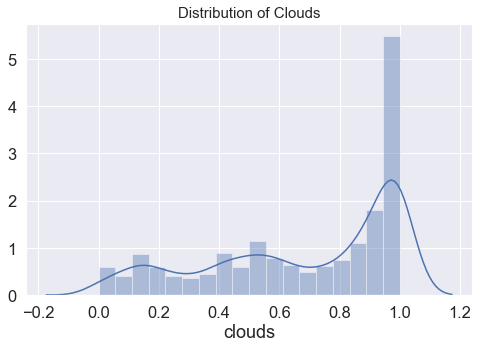

In [1848]:
plt.figure(figsize=(8,5))
sns.distplot(weather_data['clouds'])
plt.title('Distribution of Clouds', fontsize=15)

Text(0.5, 1.0, 'Distribution of Clouds')

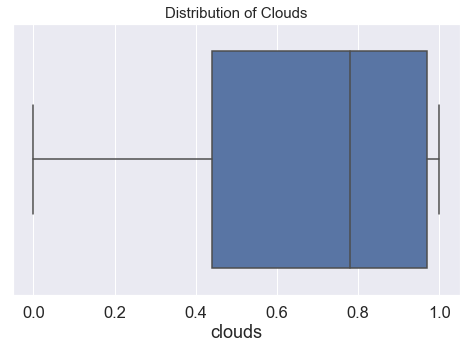

In [1849]:
plt.figure(figsize=(8,5))
sns.boxplot(weather_data['clouds'])
plt.title('Distribution of Clouds', fontsize=15)

**Pressure**

In [1850]:
weather_data['pressure'].describe()

count    6276.000000
mean     1008.445209
std        12.870775
min       988.250000
25%       997.747500
50%      1007.660000
75%      1018.480000
max      1035.120000
Name: pressure, dtype: float64

In [1851]:
calculate_mop(Pressure=weather_data['pressure'])

Pressure 

Standard deviation:     12.870774589670066
Skewness:               0.2580312741810195
Kurtosis:               -0.972776128518789



Text(0.5, 1.0, 'Distribution of Pressure')

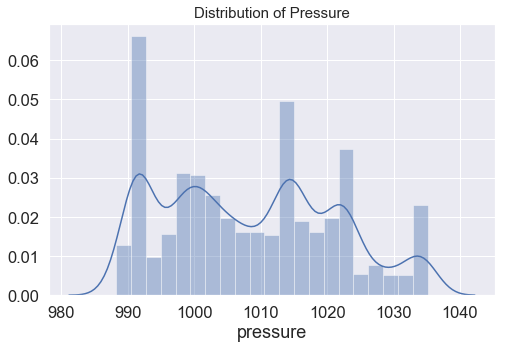

In [1852]:
plt.figure(figsize=(8,5))
sns.distplot(weather_data['pressure'])
plt.title('Distribution of Pressure', fontsize=15)

Text(0.5, 1.0, 'Distribution of Clouds')

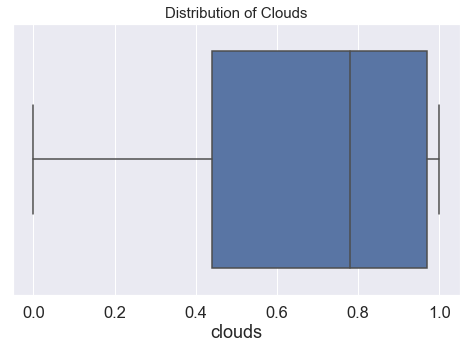

In [1853]:
plt.figure(figsize=(8,5))
sns.boxplot(weather_data['clouds'])
plt.title('Distribution of Clouds', fontsize=15)

**Rain**

In [1854]:
weather_data['rain'].describe()

count    894.000000
mean       0.057652
std        0.100758
min        0.000200
25%        0.004900
50%        0.014850
75%        0.060925
max        0.780700
Name: rain, dtype: float64

In [1855]:
calculate_mop(Rain=weather_data['rain'])

Rain 

Standard deviation:     0.10075780186235399
Skewness:               3.8076076191204042
Kurtosis:               20.156153918679006



Text(0.5, 1.0, 'Distribution of Rain')

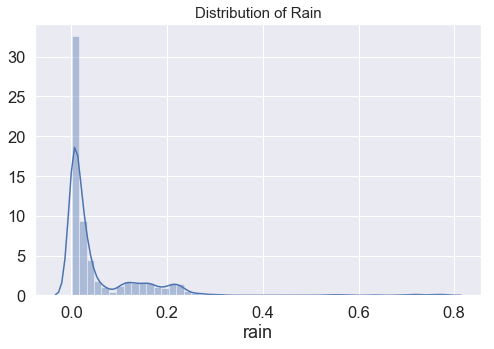

In [1856]:
plt.figure(figsize=(8,5))
a = sns.distplot(weather_data[~weather_data['rain'].isnull()]['rain'])
plt.title('Distribution of Rain', fontsize=15)

In [1857]:
# a.figure.savefig(r'C:\Users\gokul\Downloads\rain.jpg')

Text(0.5, 1.0, 'Distribution of Rain')

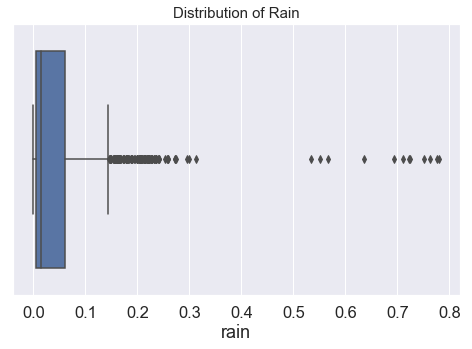

In [1858]:
plt.figure(figsize=(8,5))
sns.boxplot(weather_data[~weather_data['rain'].isnull()]['rain'])
plt.title('Distribution of Rain', fontsize=15)

In [1859]:
weather_data[weather_data['rain']>0.13].date.value_counts()

2018-11-27    140
2018-12-16      8
2018-11-26      4
Name: date, dtype: int64

**Outliers handling**

According to this website https://www.timeanddate.com/weather/usa/boston/historic?month=12&year=2018, 
there was rain only on specific days at particular hours.     
So, we've decided not to remove these outliers.

Rain is right skewed, it is understandable as this data is collected for 17 days, only in few days, there was rain
in Boston city.

**Humidity**

In [1860]:
weather_data['humidity'].describe()

count    6276.000000
mean        0.763985
std         0.127340
min         0.450000
25%         0.670000
50%         0.760000
75%         0.890000
max         0.990000
Name: humidity, dtype: float64

In [1861]:
calculate_mop(Humidity = weather_data['humidity'])

Humidity 

Standard deviation:     0.12733970290131602
Skewness:               -0.23414719562515968
Kurtosis:               -0.949730940221841



Text(0.5, 1.0, 'Distribution of Humidity')

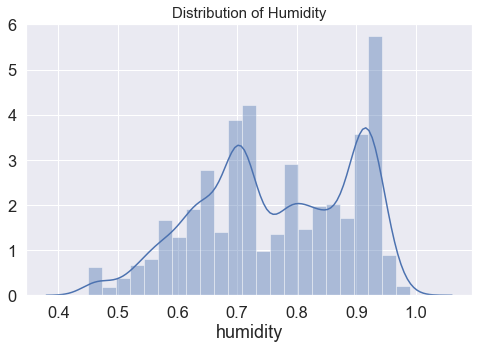

In [1862]:
plt.figure(figsize=(8,5))
sns.distplot(weather_data['humidity'])
plt.title('Distribution of Humidity', fontsize=15)

Text(0.5, 1.0, 'Distribution of Humidity')

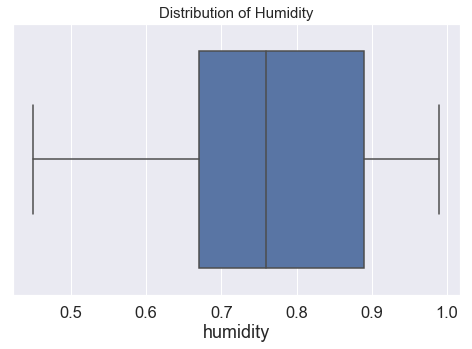

In [1863]:
plt.figure(figsize=(8,5))
sns.boxplot(weather_data['humidity'])
plt.title('Distribution of Humidity', fontsize=15)

**Wind**

In [1864]:
weather_data['wind'].describe()

count    6276.000000
mean        6.802812
std         3.633466
min         0.290000
25%         3.517500
50%         6.570000
75%         9.920000
max        18.180000
Name: wind, dtype: float64

In [1865]:
calculate_mop(Wind=weather_data['wind'])

Wind 

Standard deviation:     3.633466319108246
Skewness:               0.20356454700960958
Kurtosis:               -0.7685125750832729



Text(0.5, 1.0, 'Distribution of Wind')

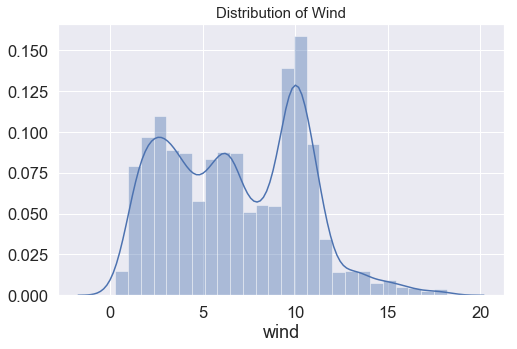

In [1866]:
plt.figure(figsize=(8,5))
sns.distplot(weather_data['wind'])
plt.title('Distribution of Wind', fontsize=15)

Text(0.5, 1.0, 'Distribution of Wind')

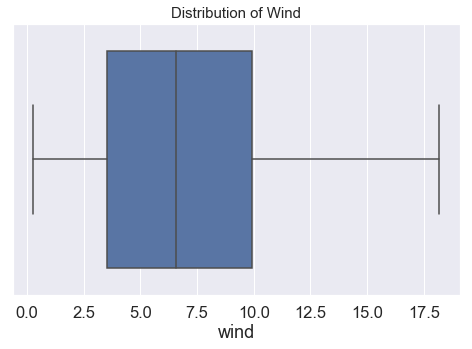

In [1867]:
plt.figure(figsize=(8,5))
sns.boxplot(weather_data['wind'])
plt.title('Distribution of Wind', fontsize=15)

**Category**

**Location**

In [1868]:
weather_data['location'].value_counts()

North End                  523
Beacon Hill                523
North Station              523
Back Bay                   523
West End                   523
Boston University          523
Theatre District           523
Fenway                     523
Financial District         523
South Station              523
Northeastern University    523
Haymarket Square           523
Name: location, dtype: int64

### Bi-variate analysis

    - temp
    - time stamp
    - clouds
    - pressure
    - rain
    - humidity
    - wind

**Continuous & Continuous**

C:\Users\gokul\Anaconda3\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\gokul\Anaconda3\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


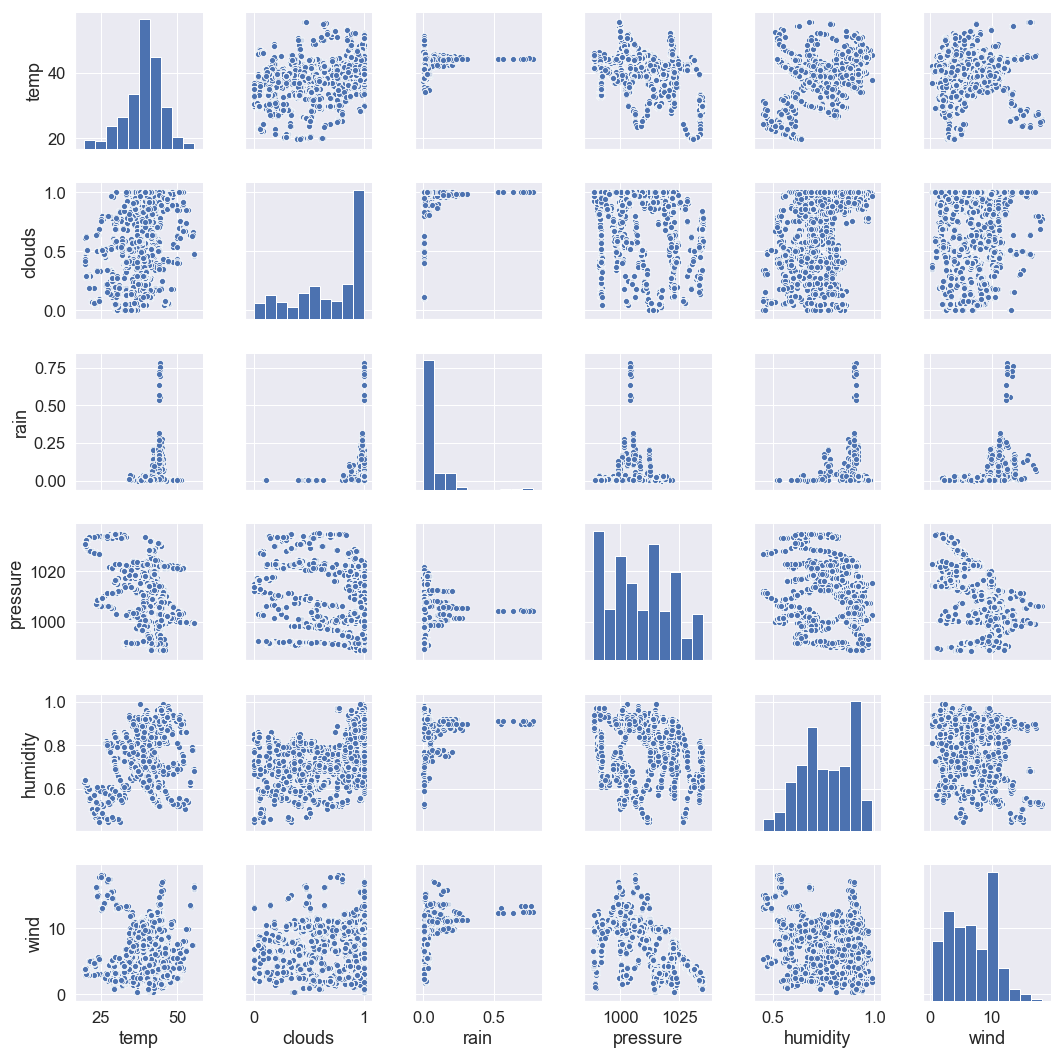

In [1869]:
sns.pairplot(weather_data[['temp', 'clouds', 'rain', 'pressure', 'humidity', 'wind']])

**Categorical & Continuous**

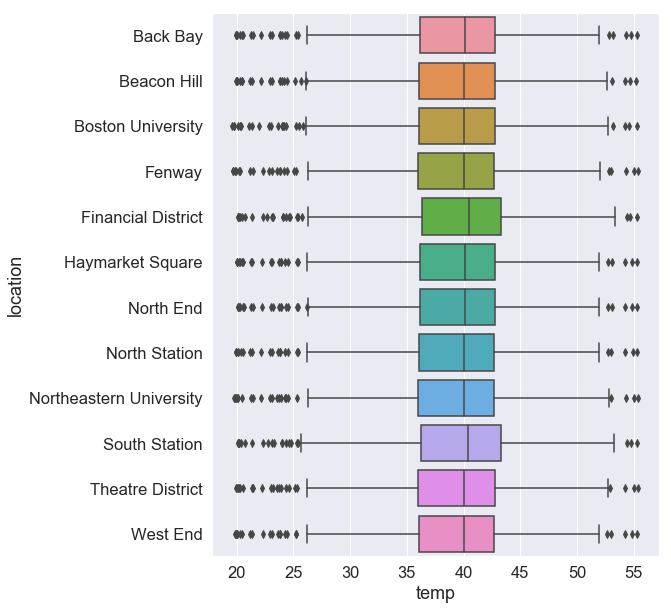

In [1870]:
sns.boxplot(weather_data['temp'], y=weather_data['location'], orient='h')

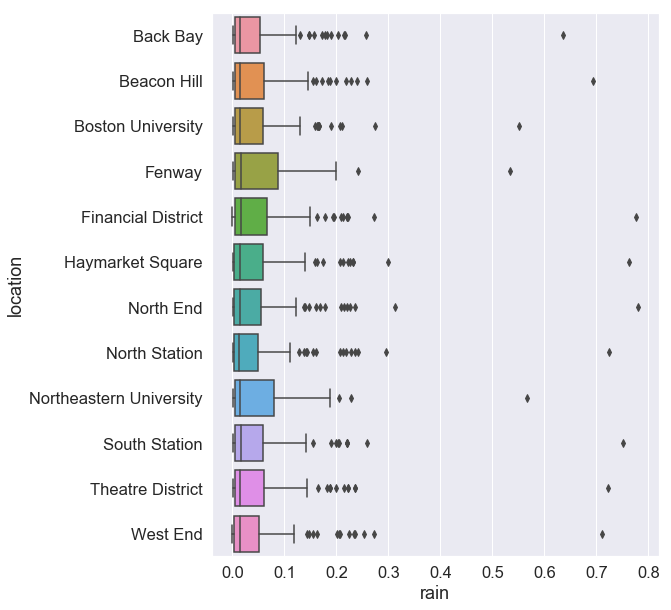

In [1871]:
sns.boxplot(weather_data['rain'], y=weather_data['location'], orient='h')

Since the data is collected within Boston city, the rain has effect on all the locations within the city,
among those locations such as Financial District, Haymarket Square and North end have experienced high rainfall.

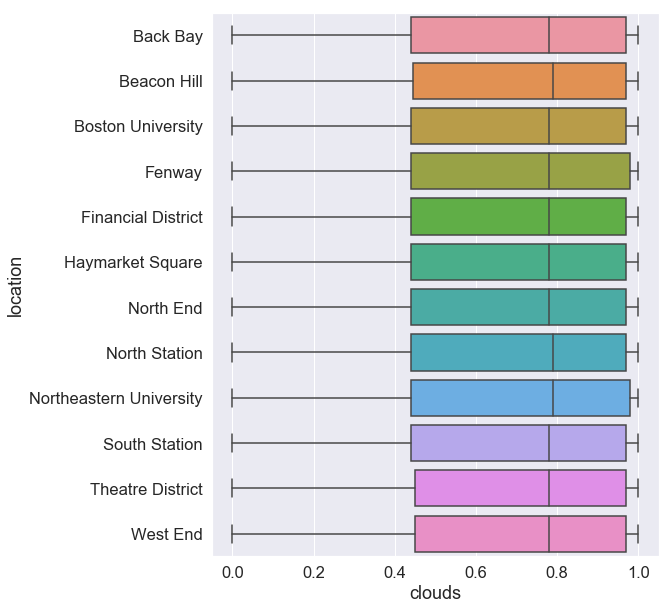

In [1872]:
sns.boxplot(weather_data['clouds'], y=weather_data['location'], orient='h')

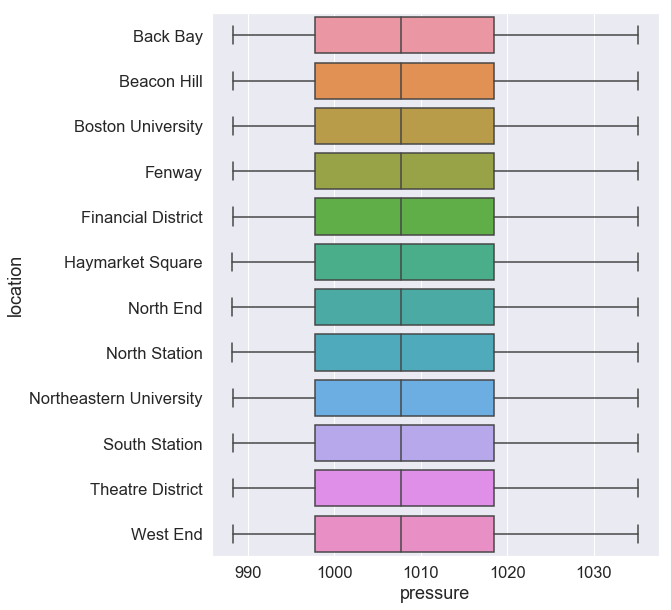

In [1873]:
sns.boxplot(weather_data['pressure'], y=weather_data['location'], orient='h')

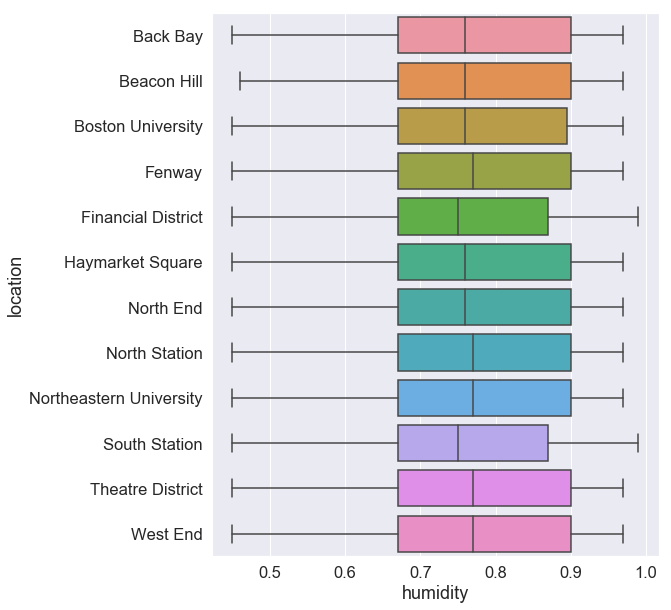

In [1874]:
sns.boxplot(weather_data['humidity'], y=weather_data['location'], orient='h')

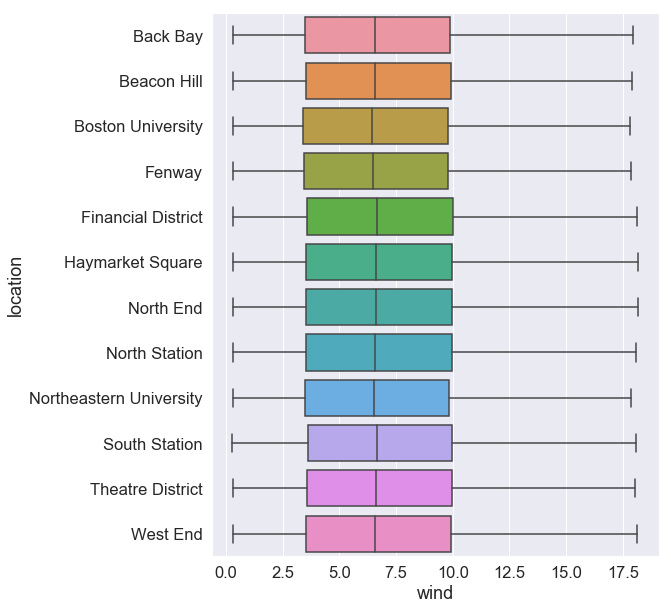

In [1875]:
sns.boxplot(weather_data['wind'], y=weather_data['location'], orient='h')

In [1876]:
weather_data['date'].value_counts().sort_index()

2018-11-26    852
2018-11-27    684
2018-11-28    948
2018-11-29    768
2018-11-30    300
2018-12-01    324
2018-12-02    288
2018-12-03    288
2018-12-04     72
2018-12-09     24
2018-12-10     72
2018-12-13    276
2018-12-14    288
2018-12-15    288
2018-12-16    288
2018-12-17    288
2018-12-18    228
Name: date, dtype: int64

### Missing Value Treatment

#### Cab rides dataset

In [1877]:
nrows, ncols = cab_data.shape
print(f'Cab ride dataset contains {nrows} rows and {ncols} columns.')

Cab ride dataset contains 693071 rows and 11 columns.


In [1878]:
mv  = cab_data.isnull().sum().sum()
prop = round(((mv/cab_data.shape[0]) * 100),3)
print(f'Cab ride dataset contains {mv} missing values, which is {prop} % of whole data.')

Cab ride dataset contains 55095 missing values, which is 7.949 % of whole data.


In [1879]:
cab_data.isnull().sum()

distance                0
cab_type                0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
date                    0
hour                    0
dtype: int64

The missing values are present in the price (target) column.

Let's check the missing values are occuring at random.

In [1880]:
# let's check the cab type
cab_data[cab_data['price'].isnull()]['cab_type'].value_counts() 

Uber    55095
Name: cab_type, dtype: int64

We can see that, the missing values are present only in the Uber data. Let's also check the car type and model.

In [1881]:
cab_data[cab_data['cab_type']=='Uber'].name.value_counts()

WAV          55096
UberXL       55096
Black SUV    55096
Taxi         55095
Black        55095
UberX        55094
UberPool     55091
Name: name, dtype: int64

In [1882]:
cab_data[cab_data['price'].isnull()]['name'].value_counts() # car model

Taxi    55095
Name: name, dtype: int64

We have checked the Uber official website for different car models, and the missing values are less than 10%
of the original data, we have decided to drop the records containing missing values in the target price feature.

In [1883]:
# let's drop those records
cab_data.dropna(how='any', inplace=True)
nrows, ncols = cab_data.shape
print(f'Now the dataset contains {nrows} rows and {ncols} columns.')

uber = cab_data[cab_data['cab_type']=='Uber']
lyft = cab_data[cab_data['cab_type']=='Lyft']

Now the dataset contains 637976 rows and 11 columns.


In [1884]:
cab_data.isnull().sum().sum() # check for missing values

0

In [1885]:
# cab_data.to_csv('C:\Users\gokul\Downloads\cabs.csv')

**Weather dataset**

In [1886]:
nrows, ncols = weather_data.shape
print(f'Cab ride dataset contains {nrows} rows and {ncols} columns.')

Cab ride dataset contains 6276 rows and 9 columns.


In [1887]:
mv  = weather_data.isnull().sum().sum()
prop = round(((mv/weather_data.shape[0]) * 100),3)
print(f'Cab ride dataset contains {mv} missing values, which is {prop} % of whole data.')

Cab ride dataset contains 5382 missing values, which is 85.755 % of whole data.


In [1888]:
weather_data.isnull().sum()

temp           0
location       0
clouds         0
pressure       0
rain        5382
humidity       0
wind           0
date           0
hour           0
dtype: int64

We can see that, in the 'rain' feature 85.75 % of the data is missing. After checking the weather conditions from the 
official website of Boston and through observation, we can infer that,      
The missing values are due to unobserved input variable, that is there was no rain observed on those particular hour.        

So, we have decided to impute the missing values with zero, which denotes no rain.

In [1889]:
# let's impute the missing values in the 'rain' column with 0
weather_data['rain'].fillna(0, inplace=True)

In [1890]:
weather_data.isnull().sum().sum() # check for missing values

0

### Base Model

In [1891]:
# weather data supposed to contain 1 record per hour, since it has more than one values for few hours, 
# we took groupby average
weather_data = weather_data.groupby(['location','date', 'hour']).mean()
weather_data.reset_index(inplace=True)

In [1892]:
merged_data = pd.merge(cab_data, weather_data, how='left', left_on=['source', 'date', 'hour'],
        right_on=['location', 'date', 'hour'])

In [1893]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637976 entries, 0 to 637975
Data columns (total 18 columns):
distance            637976 non-null float64
cab_type            637976 non-null object
destination         637976 non-null object
source              637976 non-null object
price               637976 non-null float64
surge_multiplier    637976 non-null float64
id                  637976 non-null object
product_id          637976 non-null object
name                637976 non-null object
date                637976 non-null object
hour                637976 non-null int64
location            635240 non-null object
temp                635240 non-null float64
clouds              635240 non-null float64
pressure            635240 non-null float64
rain                635240 non-null float64
humidity            635240 non-null float64
wind                635240 non-null float64
dtypes: float64(9), int64(1), object(8)
memory usage: 92.5+ MB


We could see that there is null values in the data.

In [1894]:
merged_data[merged_data.temp.isnull()].groupby(['source', 'date', 'hour']).mean().head(6)

distance      price  surge_multiplier  temp  \
source      date       hour                                                
Back Bay    2018-11-28 1     1.400000  13.395833               1.0   NaN   
            2018-12-04 6     1.798889  13.937500               1.0   NaN   
            2018-12-18 19    3.260000  17.875000               1.0   NaN   
Beacon Hill 2018-11-28 1     1.575000  13.864583               1.0   NaN   
            2018-12-04 6     2.028500  14.470833               1.0   NaN   
            2018-12-18 19    2.505000  16.208333               1.0   NaN   

                             clouds  pressure  rain  humidity  wind  
source      date       hour                                          
Back Bay    2018-11-28 1        NaN       NaN   NaN       NaN   NaN  
            2018-12-04 6        NaN       NaN   NaN       NaN   NaN  
            2018-12-18 19       NaN       NaN   NaN       NaN   NaN  
Beacon Hill 2018-11-28 1        NaN       NaN   NaN       NaN   NaN  
            2018-12-04 6        NaN       NaN   NaN       NaN   NaN  
            2018-12-18 19       NaN       NaN   NaN       NaN   NaN

Weather data doesn't have records for this particular dates and hours, let's impute these values with the previous values.

In [1895]:
df1 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 11, 28)) &
    (weather_data['hour']==0)]

df2 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 12, 4)) &
    (weather_data['hour']==5)]
df3 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 11, 28)) &
    (weather_data['hour']==2)]
df4 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 12, 4)) &
    (weather_data['hour']==7)]


lookup = pd.concat([df1, df2, df3, df4])
lookup = lookup.groupby(['hour', 'location', 'date']).mean().reset_index()
df5 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 12, 18)) &
    (weather_data['hour']==18)]

lookup = pd.concat([lookup, df5])
lookup['hour'] += 1
lookup.reset_index(inplace=True)

C:\Users\gokul\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [1896]:
weather_data = pd.concat([weather_data, lookup], ignore_index=True) 

C:\Users\gokul\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [1897]:
weather_data.shape

(3996, 10)

In [1898]:
cab_data = pd.merge(cab_data, weather_data, how='left',
                left_on=['source', 'date', 'hour'],
                right_on=['location', 'date', 'hour'])

In [1899]:
cab_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637976 entries, 0 to 637975
Data columns (total 19 columns):
distance            637976 non-null float64
cab_type            637976 non-null object
destination         637976 non-null object
source              637976 non-null object
price               637976 non-null float64
surge_multiplier    637976 non-null float64
id                  637976 non-null object
product_id          637976 non-null object
name                637976 non-null object
date                637976 non-null object
hour                637976 non-null int64
clouds              637976 non-null float64
humidity            637976 non-null float64
index               2736 non-null float64
location            637976 non-null object
pressure            637976 non-null float64
rain                637976 non-null float64
temp                637976 non-null float64
wind                637976 non-null float64
dtypes: float64(10), int64(1), object(8)
memory usage: 97.3+ MB


In [1900]:
cab_data.drop('index', axis=1, inplace=True)

In [1901]:
cab_data.shape, cab_data.drop_duplicates().shape

((637976, 18), (637976, 18))

In [1902]:
# drop unnecessary features
cab_data = cab_data.drop(['id', 'product_id', 'location', 'date'], axis=1)

In [1903]:
corr_m = cab_data.corr()

In [1904]:
x = np.tri(corr_m.shape[0],k=-1)

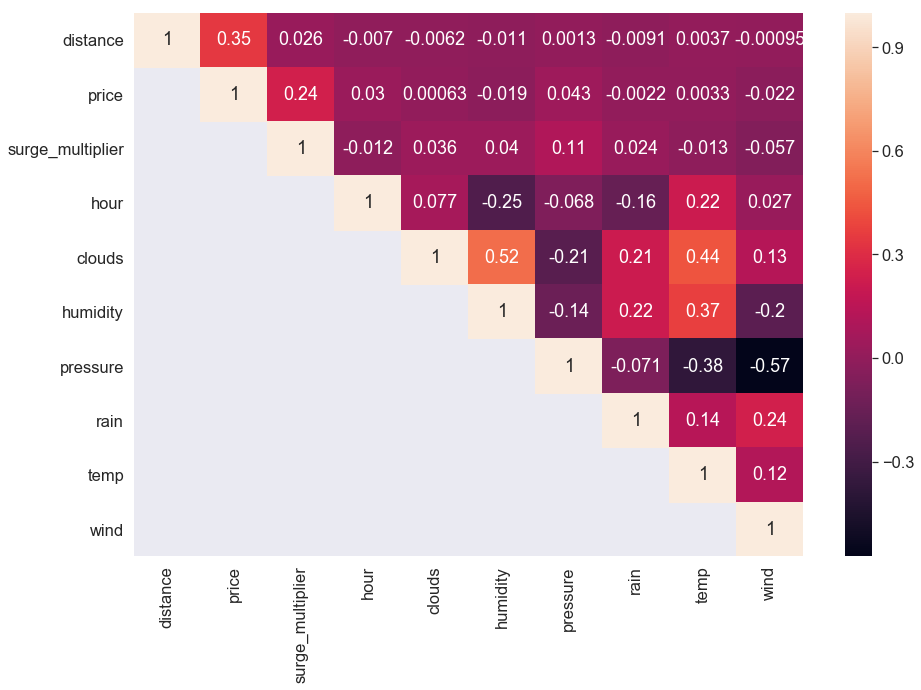

In [1905]:
plt.figure(figsize=(15,10))
a = sns.heatmap(corr_m, annot=True, mask=x)

In [1906]:
# a.figure.savefig(r'C:\Users\gokul\Downloads\corr.jpg')

In [1907]:
# Initial data preparation

In [1908]:
data = cab_data.drop(['price', 'surge_multiplier'], axis=1) # we are dropping surge multiplier, to avoid data leak
labels = cab_data['price'].copy()

In [1909]:
# model building libraries

# from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [1910]:
uber = cab_data[cab_data['cab_type']=='Uber']
uber.reset_index(inplace=True)
uber.drop('index', axis=1, inplace=True)
lyft = cab_data[cab_data['cab_type']=='Lyft']
lyft.reset_index(inplace=True)
lyft.drop('index', axis=1, inplace=True)

C:\Users\gokul\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [1920]:
uber.drop('cab_type', axis=1, inplace=True)
lyft.drop('cab_type', axis=1, inplace=True)

In [1921]:
lyft_data = lyft.copy() # backups
uber_data = uber.copy()

In [1922]:
uber_data.head()

,distance,destination,source,price,surge_multiplier,name,hour,clouds,humidity,pressure,rain,temp,wind
0,2.46,Beacon Hill,Fenway,9.5,1.0,WAV,6,1.000000,0.915000,997.125000,0.015350,44.140000,12.040000
1,1.41,Theatre District,North End,12.5,1.0,UberXL,8,0.620000,0.610000,1030.210000,0.000000,20.210000,3.810000
2,3.31,Northeastern University,North Station,10.5,1.0,UberX,2,0.447143,0.707143,998.042857,0.000857,38.182857,10.551429
3,3.30,Northeastern University,North Station,9.5,1.0,UberPool,21,0.760000,0.630000,1034.390000,0.000000,31.550000,2.030000
4,2.34,Back Bay,North End,9.5,1.0,UberX,10,0.990000,0.900000,1021.640000,0.000000,45.970000,5.700000


In [1923]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264454 entries, 0 to 264453
Data columns (total 13 columns):
distance            264454 non-null float64
destination         264454 non-null object
source              264454 non-null object
price               264454 non-null float64
surge_multiplier    264454 non-null float64
name                264454 non-null object
hour                264454 non-null int64
clouds              264454 non-null float64
humidity            264454 non-null float64
pressure            264454 non-null float64
rain                264454 non-null float64
temp                264454 non-null float64
wind                264454 non-null float64
dtypes: float64(9), int64(1), object(3)
memory usage: 26.2+ MB


**Categorical columns encoding**

**One Hot encoding**

In [1924]:
ohe = OneHotEncoder()
car_type = pd.DataFrame(ohe.fit_transform(uber[['name']]).toarray(), columns=sorted(list(uber['name'].unique())))
source = pd.DataFrame(ohe.fit_transform(uber[['source']]).toarray(), 
                       columns=['src_'+loc for loc in sorted(list(uber['source'].unique()))])
destination = pd.DataFrame(ohe.fit_transform(uber[['destination']]).toarray(), 
                           columns=['dest_'+loc for loc in sorted(list(uber['destination'].unique()))])

In [1925]:
ohe = OneHotEncoder()
lyft_car_type = pd.DataFrame(ohe.fit_transform(lyft[['name']]).toarray(), columns=sorted(list(lyft['name'].unique())))
lyft_source = pd.DataFrame(ohe.fit_transform(lyft[['source']]).toarray(),
                           columns=['src_'+loc for loc in sorted(list(lyft['source'].unique()))])
lyft_destination = pd.DataFrame(ohe.fit_transform(lyft[['destination']]).toarray(),
                                columns=['dest_'+loc for loc in sorted(list(lyft['destination'].unique()))])

In [1926]:
uber = pd.concat([uber, car_type, source, destination], axis=1)
uber.drop(['name', 'source', 'destination'], axis=1, inplace=True)

In [1927]:
lyft = pd.concat([lyft, lyft_car_type, lyft_source, lyft_destination], axis=1)
lyft.drop(['name', 'source', 'destination'], axis=1, inplace=True)

**Label Encoding**

In [1928]:
from sklearn.preprocessing import LabelEncoder

In [1929]:
uber_le = uber_data.copy()
lyft_le = lyft_data.copy()

lb = LabelEncoder()

uber_le['name'] = lb.fit_transform(uber_data['name'])
uber_le['source'] = lb.fit_transform(uber_data['source'])
uber_le['destination'] = lb.fit_transform(uber_data['destination'])

lyft_le['name'] = lb.fit_transform(lyft_le['name'])
lyft_le['source'] = lb.fit_transform(lyft_le['source'])
lyft_le['destination'] = lb.fit_transform(lyft_le['destination'])

In [1930]:
uber_leX = uber_le.drop(['price', 'surge_multiplier'], axis=1)
uber_ley = uber_le['price'].copy()

lyft_leX = lyft_le.drop(['price', 'surge_multiplier'], axis=1)
lyft_ley = lyft_le['price'].copy()

In [1931]:
uber_X = uber.drop(['price', 'surge_multiplier'], axis=1)
uber_y = uber['price'].copy()

In [1932]:
lyft_X = lyft.drop(['price', 'surge_multiplier'], axis=1)
lyft_y = lyft['price'].copy()

In [1933]:
uber_leX.shape

(264454, 11)

In [1934]:
lyft_leX.shape

(245926, 11)

In [1935]:
import statsmodels.api as sm

**Uber base model**

In [1936]:
x_constant = sm.add_constant(uber_X)
uber_model = sm.OLS(uber_y, x_constant).fit()
uber_model.summary()

C:\Users\gokul\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 9.480e+04
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:57:45   Log-Likelihood:            -6.0239e+05
No. Observations:              264454   AIC:                         1.205e+06
Df Residuals:                  264419   BIC:                         1.205e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -18.6876      0.385    -48.548      0.000     -19.442     -17.933
distance                         2.5325      0.005    513.221      0.000       2.523       2.542
hour                             0.0222      0.001     29.396      0.000       0.021       0.024
clouds                           0.1258      0.019      6.545      0.000       0.088       0.164
humidity                        -0.5708      0.052    -10.991      0.000      -0.673      -0.469
pressure                         0.0338      0.000     70.313      0.000       0.033       0.035
rain                             2.3276      0.164     14.191      0.000       2.006       2.649
temp                             0.0280      0.001     31.737      0.000       0.026       0.030
wind                            -0.0022      0.002     -1.196      0.232      -0.006       0.001
Black                            1.6157      0.065     24.869      0.000       1.488       1.743
Black SUV                       11.3776      0.065    175.095      0.000      11.250      11.505
UberPool                       -10.1541      0.065   -156.292      0.000     -10.281     -10.027
UberX                           -9.1501      0.065   -140.830      0.000      -9.277      -9.023
UberXL                          -3.2296      0.065    -49.711      0.000      -3.357      -3.102
WAV                             -9.1471      0.065   -140.792      0.000      -9.274      -9.020
src_Back Bay                    -1.7011      0.035    -48.360      0.000      -1.770      -1.632
src_Beacon Hill                 -1.9044      0.035    -54.116      0.000      -1.973      -1.835
src_Boston University           -1.8058      0.035    -50.928      0.000      -1.875      -1.736
src_Fenway                      -1.7276      0.035    -48.800      0.000      -1.797      -1.658
src_Financial District          -1.2414      0.035    -35.072      0.000      -1.311      -1.172
src_Haymarket Square            -1.1230      0.036    -31.451      0.000      -1.193      -1.053
src_North End                   -1.0806      0.035    -30.500      0.000      -1.150      -1.011
src_North Station               -1.5267      0.035    -43.286      0.000      -1.596      -1.458
src_Northeastern University     -2.0337      0.035    -57.355      0.000      -2.103      -1.964
src_South Station               -1.5329      0.035    -43.411      0.000      -1.602      -1.464
src_Theatre District            -1.3764      0.035    -38.812      0.000      -1.446      -1.307
src_West End                    -1.6340      0.035    -46.087      0.000      -1.704      -1.565
dest_Back Bay                   -1.5408      0.035    -43.775      0.000      -1.610      -1.472
dest_Beacon Hill                -1.7965      0.035    -50.991      0.000    

We could see that Wind doesn't have significant impact on the price column.

**Lyft base model**

In [1937]:
x_constant = sm.add_constant(lyft_X)
lyft_model = sm.OLS(lyft_y, x_constant).fit()
lyft_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                 5.529e+04
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:57:47   Log-Likelihood:            -6.5020e+05
No. Observations:              245926   AIC:                         1.300e+06
Df Residuals:                  245891   BIC:                         1.301e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -19.8979      0.562    -35.381      0.000     -21.000     -18.796
distance                         3.4800      0.009    395.572      0.000       3.463       3.497
hour                             0.0668      0.001     59.667      0.000       0.065       0.069
clouds                           0.5742      0.028     20.560      0.000       0.519       0.629
humidity                        -0.7114      0.077     -9.254      0.000      -0.862      -0.561
pressure                         0.0350      0.001     50.018      0.000       0.034       0.036
rain                             2.1123      0.236      8.944      0.000       1.649       2.575
temp                             0.0084      0.001      6.584      0.000       0.006       0.011
wind                            -0.0131      0.003     -4.856      0.000      -0.018      -0.008
Lux                             -2.8896      0.095    -30.417      0.000      -3.076      -2.703
Lux Black                        2.3854      0.095     25.114      0.000       2.199       2.572
Lux Black XL                    11.6588      0.095    122.730      0.000      11.473      11.845
Lyft                           -11.0561      0.095   -116.431      0.000     -11.242     -10.870
Lyft XL                         -5.3589      0.095    -56.425      0.000      -5.545      -5.173
Shared                         -14.6374      0.095   -154.119      0.000     -14.824     -14.451
src_Back Bay                    -1.0109      0.052    -19.577      0.000      -1.112      -0.910
src_Beacon Hill                 -2.0986      0.052    -40.648      0.000      -2.200      -1.997
src_Boston University           -2.0047      0.052    -38.377      0.000      -2.107      -1.902
src_Fenway                      -1.5529      0.052    -29.851      0.000      -1.655      -1.451
src_Financial District          -1.7395      0.052    -33.533      0.000      -1.841      -1.638
src_Haymarket Square            -1.7220      0.053    -32.797      0.000      -1.825      -1.619
src_North End                   -1.5473      0.052    -29.732      0.000      -1.649      -1.445
src_North Station               -2.2483      0.052    -43.392      0.000      -2.350      -2.147
src_Northeastern University     -1.5963      0.052    -30.712      0.000      -1.698      -1.494
src_South Station               -1.3536      0.052    -26.120      0.000      -1.455      -1.252
src_Theatre District            -0.9337      0.052    -17.927      0.000      -1.036      -0.832
src_West End                    -2.0901      0.052    -40.205      0.000      -2.192      -1.988
dest_Back Bay                   -1.7426      0.052    -33.766      0.000      -1.844      -1.641
dest_Beacon Hill                -2.1526      0.052    -41.735      0.000    

We could see that all the features are significant in the Lyft model, according to the p-values.

In [1938]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

In [1939]:
X_train, X_test, y_train, y_test = train_test_split(uber_X, uber_y, test_size=0.3, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1940]:
train_pred = lin_reg.predict(X_train)
print(f'Train score {np.sqrt(mean_squared_error(y_train, train_pred))}')

predicted = lin_reg.predict(X_test)
print(f'Test score {np.sqrt(mean_squared_error(y_test, predicted))}')

Train score 2.35529477706234
Test score 2.373171395703017


In [1941]:
X_train, X_test, y_train, y_test = train_test_split(lyft_X, lyft_y, test_size=0.3, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1942]:
train_pred = lin_reg.predict(X_train)
print(f'Train score {np.sqrt(mean_squared_error(y_train, train_pred))}')

predicted = lin_reg.predict(X_test)
print(f'Test score {np.sqrt(mean_squared_error(y_test, predicted))}')

Train score 3.4041882837110884
Test score 3.403919884051956


### Hypothesis Testing

**Price and Source**

In [1943]:
import statsmodels.api         as     sm
from   statsmodels.formula.api import ols
 
mod = ols('price ~ source', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq        df           F  PR(>F)
source    4.278632e+05      11.0  541.084944     0.0
Residual  1.900978e+07  264442.0         NaN     NaN


In [1944]:
mod = ols('price ~ source', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq        df           F  PR(>F)
source    7.678312e+05      11.0  719.213955     0.0
Residual  2.386702e+07  245914.0         NaN     NaN


**Price and Destination**

In [1945]:
mod = ols('price ~ destination', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                   sum_sq        df           F  PR(>F)
destination  3.497809e+05      11.0  440.531021     0.0
Residual     1.908787e+07  264442.0         NaN     NaN


In [1946]:
mod = ols('price ~ destination', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                   sum_sq        df           F  PR(>F)
destination  7.002879e+05      11.0  654.096317     0.0
Residual     2.393456e+07  245914.0         NaN     NaN


**Price and Name**

In [1947]:
mod = ols('price ~ name', data = uber_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq        df              F  PR(>F)
name      1.567748e+07       5.0  220515.698653     0.0
Residual  3.760166e+06  264448.0            NaN     NaN


In [1948]:
mod = ols('price ~ name', data = lyft_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq        df             F  PR(>F)
name      1.839885e+07       5.0  145113.76562     0.0
Residual  6.235998e+06  245920.0           NaN     NaN


**Price and Cab type**

In [1949]:
mod = ols('price ~ cab_type', data = cab_data).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq        df            F  PR(>F)
cab_type  3.856740e+05       1.0  4466.959446     0.0
Residual  5.508221e+07  637974.0          NaN     NaN


## Feature Selection

### 1. Correlation

In [1975]:
lyft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245926 entries, 0 to 245925
Data columns (total 13 columns):
distance            245926 non-null float64
destination         245926 non-null object
source              245926 non-null object
price               245926 non-null float64
surge_multiplier    245926 non-null float64
name                245926 non-null object
hour                245926 non-null int64
clouds              245926 non-null float64
humidity            245926 non-null float64
pressure            245926 non-null float64
rain                245926 non-null float64
temp                245926 non-null float64
wind                245926 non-null float64
dtypes: float64(9), int64(1), object(3)
memory usage: 24.4+ MB


**Lyft**

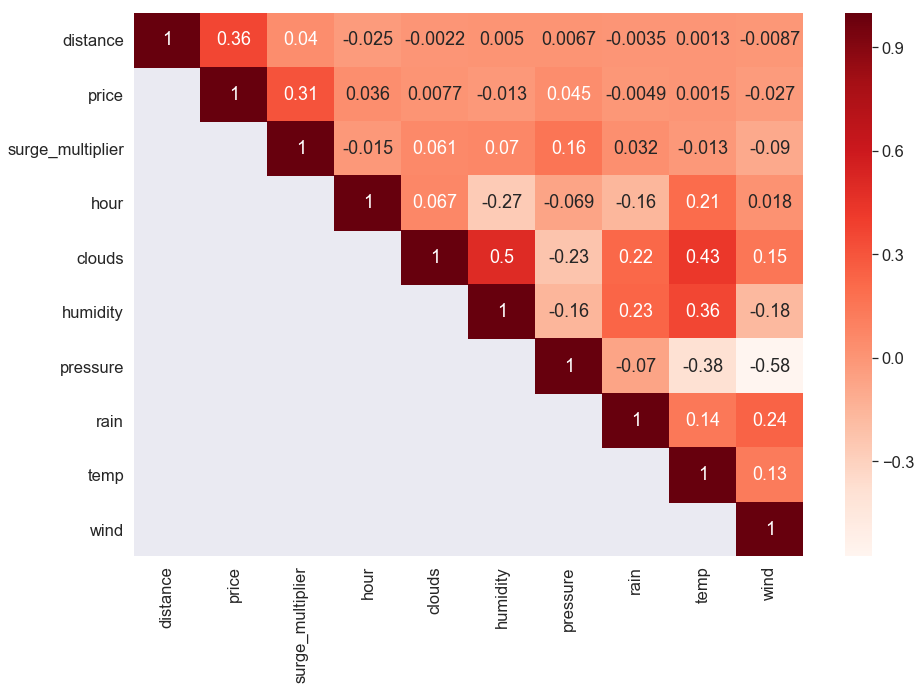

In [1976]:
plt.figure(figsize=(15,10))
corr_m = lyft_data.corr()
x = np.tri(corr_m.shape[0],k=-1)
sns.heatmap(corr_m, annot=True, cmap=plt.cm.Reds, mask=x)
plt.show()

In [1977]:
corr_m['price'].abs().sort_values(ascending=False)[1:]

distance            0.360826
surge_multiplier    0.307160
pressure            0.045021
hour                0.035598
wind                0.027202
humidity            0.013333
clouds              0.007735
rain                0.004924
temp                0.001478
Name: price, dtype: float64

From the correlation, we can see distance is moderately correlated,           
followed by pressure, hour and wind. (we can ignore surge multiplier, as it leaks info about price.)          
Rain and temperature are not significant.

**Uber**

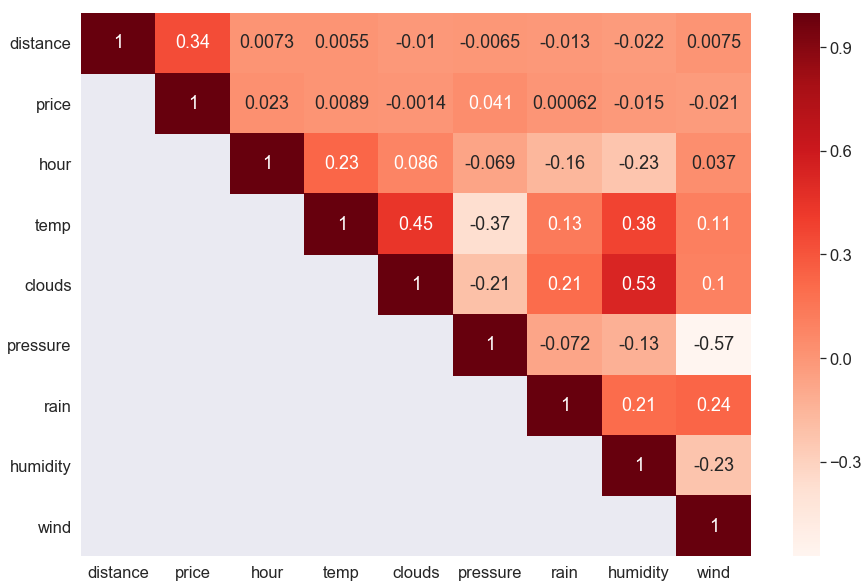

In [1509]:
plt.figure(figsize=(15,10))
corr_m = uber_data[['distance', 'destination', 'source', 'price','name', 'hour', 'temp', 'clouds', 'pressure', 'rain', 'humidity',
       'wind']].corr()
x = np.tri(corr_m.shape[0],k=-1)
sns.heatmap(corr_m, annot=True, cmap=plt.cm.Reds, mask=x)
plt.show()

In [1510]:
corr_m['price'].abs().sort_values(ascending=False)[1:]

distance    0.338690
pressure    0.041466
hour        0.022840
wind        0.020527
humidity    0.015395
temp        0.008859
clouds      0.001368
rain        0.000625
Name: price, dtype: float64

From the correlation, we can see distance is moderately correlated,           
followed by pressure, hour and wind.          
Rain and clouds are not significant.

In [1512]:
uber1_X = uber_X.copy()
uber1_y = uber_y.copy()

In [1513]:
lyft1_X = lyft_X
lyft1_y = lyft_y

### 2. Backward Elimination

**Uber**

In [1514]:
#Backward Elimination
cols = list(uber1_X.columns)
pmax = 1
counter=0
while (len(cols)>0):
    p= []
    counter+=1

    X_1 = uber1_X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(uber1_y,X_1).fit()
#     print(counter)
#     print(len(pd.Series(model.pvalues.values)))
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
#         print('inside')
        cols.remove(feature_with_p_max)
    else:
        break
    print(feature_with_p_max)
#     print(len(cols))
selected_features_BE = cols
print(selected_features_BE)

C:\Users\gokul\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


wind
['distance', 'hour', 'clouds', 'humidity', 'pressure', 'rain', 'temp', 'Black', 'Black SUV', 'UberPool', 'UberX', 'UberXL', 'WAV', 'src_Back Bay', 'src_Beacon Hill', 'src_Boston University', 'src_Fenway', 'src_Financial District', 'src_Haymarket Square', 'src_North End', 'src_North Station', 'src_Northeastern University', 'src_South Station', 'src_Theatre District', 'src_West End', 'dest_Back Bay', 'dest_Beacon Hill', 'dest_Boston University', 'dest_Fenway', 'dest_Financial District', 'dest_Haymarket Square', 'dest_North End', 'dest_North Station', 'dest_Northeastern University', 'dest_South Station', 'dest_Theatre District', 'dest_West End']


In [1515]:
len(selected_features_BE)

37

In [1516]:
uber2 = uber1_X[selected_features_BE]

In [1517]:
uber2_X = uber2
uber2_y = uber_data['price'].copy()

In [1518]:
x_constant = sm.add_constant(uber2_X)
uber_model = sm.OLS(uber2_y, x_constant).fit()
uber_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 9.767e+04
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:12:33   Log-Likelihood:            -6.0239e+05
No. Observations:              264454   AIC:                         1.205e+06
Df Residuals:                  264420   BIC:                         1.205e+06
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -18.9846      0.294    -64.539      0.000     -19.561     -18.408
distance                         2.5325      0.005    513.228      0.000       2.523       2.542
hour                             0.0223      0.001     29.690      0.000       0.021       0.024
clouds                           0.1207      0.019      6.440      0.000       0.084       0.157
humidity                        -0.5424      0.046    -11.742      0.000      -0.633      -0.452
pressure                         0.0342      0.000     90.661      0.000       0.033       0.035
rain                             2.2657      0.156     14.558      0.000       1.961       2.571
temp                             0.0281      0.001     31.816      0.000       0.026       0.030
Black                            1.5662      0.050     31.270      0.000       1.468       1.664
Black SUV                       11.3281      0.050    226.091      0.000      11.230      11.426
UberPool                       -10.2036      0.050   -203.732      0.000     -10.302     -10.105
UberX                           -9.1996      0.050   -183.649      0.000      -9.298      -9.101
UberXL                          -3.2791      0.050    -65.474      0.000      -3.377      -3.181
WAV                             -9.1966      0.050   -183.620      0.000      -9.295      -9.098
src_Back Bay                    -1.7257      0.029    -60.473      0.000      -1.782      -1.670
src_Beacon Hill                 -1.9291      0.028    -67.729      0.000      -1.985      -1.873
src_Boston University           -1.8303      0.029    -63.226      0.000      -1.887      -1.774
src_Fenway                      -1.7522      0.029    -60.835      0.000      -1.809      -1.696
src_Financial District          -1.2660      0.029    -43.960      0.000      -1.322      -1.210
src_Haymarket Square            -1.1480      0.029    -39.620      0.000      -1.205      -1.091
src_North End                   -1.1055      0.029    -38.552      0.000      -1.162      -1.049
src_North Station               -1.5514      0.029    -54.282      0.000      -1.607      -1.495
src_Northeastern University     -2.0585      0.029    -71.506      0.000      -2.115      -2.002
src_South Station               -1.5576      0.029    -54.318      0.000      -1.614      -1.501
src_Theatre District            -1.4014      0.029    -48.901      0.000      -1.458      -1.345
src_West End                    -1.6590      0.029    -57.878      0.000      -1.715      -1.603
dest_Back Bay                   -1.5654      0.029    -54.818      0.000      -1.621      -1.509
dest_Beacon Hill                -1.8212      0.029    -63.842      0.000      -1.877      -1.765
dest_Boston University          -1.4512      0.029    -50.256      0.000    

**Lyft**

In [1519]:
#Backward Elimination
cols = list(lyft1_X.columns)
pmax = 1
counter=0
while (len(cols)>0):
    p= []
    counter+=1
    X_1 = lyft1_X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(lyft1_y,X_1).fit()
#     print(counter)
#     print(len(pd.Series(model.pvalues.values)))
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
#         print('inside')
        cols.remove(feature_with_p_max)
    else:
        break
    print(feature_with_p_max)
#     print(len(cols))
selected_features_BE = cols
print('\n',selected_features_BE)


 ['distance', 'hour', 'clouds', 'humidity', 'pressure', 'rain', 'temp', 'wind', 'Lux', 'Lux Black', 'Lux Black XL', 'Lyft', 'Lyft XL', 'Shared', 'src_Back Bay', 'src_Beacon Hill', 'src_Boston University', 'src_Fenway', 'src_Financial District', 'src_Haymarket Square', 'src_North End', 'src_North Station', 'src_Northeastern University', 'src_South Station', 'src_Theatre District', 'src_West End', 'dest_Back Bay', 'dest_Beacon Hill', 'dest_Boston University', 'dest_Fenway', 'dest_Financial District', 'dest_Haymarket Square', 'dest_North End', 'dest_North Station', 'dest_Northeastern University', 'dest_South Station', 'dest_Theatre District', 'dest_West End']


In [1520]:
len(selected_features_BE)

38

In [1521]:
lyft2 = lyft1_X[selected_features_BE]

In [1522]:
lyft2_X = lyft2
lyft2_y = lyft_data['price'].copy()

In [1523]:
x_constant = sm.add_constant(lyft2_X)
lyft_model = sm.OLS(lyft2_y, x_constant).fit()
lyft_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                 5.529e+04
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:12:37   Log-Likelihood:            -6.5020e+05
No. Observations:              245926   AIC:                         1.300e+06
Df Residuals:                  245891   BIC:                         1.301e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -19.8979      0.562    -35.381      0.000     -21.000     -18.796
distance                         3.4800      0.009    395.572      0.000       3.463       3.497
hour                             0.0668      0.001     59.667      0.000       0.065       0.069
clouds                           0.5742      0.028     20.560      0.000       0.519       0.629
humidity                        -0.7114      0.077     -9.254      0.000      -0.862      -0.561
pressure                         0.0350      0.001     50.018      0.000       0.034       0.036
rain                             2.1123      0.236      8.944      0.000       1.649       2.575
temp                             0.0084      0.001      6.584      0.000       0.006       0.011
wind                            -0.0131      0.003     -4.856      0.000      -0.018      -0.008
Lux                             -2.8896      0.095    -30.417      0.000      -3.076      -2.703
Lux Black                        2.3854      0.095     25.114      0.000       2.199       2.572
Lux Black XL                    11.6588      0.095    122.730      0.000      11.473      11.845
Lyft                           -11.0561      0.095   -116.431      0.000     -11.242     -10.870
Lyft XL                         -5.3589      0.095    -56.425      0.000      -5.545      -5.173
Shared                         -14.6374      0.095   -154.119      0.000     -14.824     -14.451
src_Back Bay                    -1.0109      0.052    -19.577      0.000      -1.112      -0.910
src_Beacon Hill                 -2.0986      0.052    -40.648      0.000      -2.200      -1.997
src_Boston University           -2.0047      0.052    -38.377      0.000      -2.107      -1.902
src_Fenway                      -1.5529      0.052    -29.851      0.000      -1.655      -1.451
src_Financial District          -1.7395      0.052    -33.533      0.000      -1.841      -1.638
src_Haymarket Square            -1.7220      0.053    -32.797      0.000      -1.825      -1.619
src_North End                   -1.5473      0.052    -29.732      0.000      -1.649      -1.445
src_North Station               -2.2483      0.052    -43.392      0.000      -2.350      -2.147
src_Northeastern University     -1.5963      0.052    -30.712      0.000      -1.698      -1.494
src_South Station               -1.3536      0.052    -26.120      0.000      -1.455      -1.252
src_Theatre District            -0.9337      0.052    -17.927      0.000      -1.036      -0.832
src_West End                    -2.0901      0.052    -40.205      0.000      -2.192      -1.988
dest_Back Bay                   -1.7426      0.052    -33.766      0.000      -1.844      -1.641
dest_Beacon Hill                -2.1526      0.052    -41.735      0.000    

**Select Features**

In [1978]:
uber_X = uber_X.drop(['wind', 'temp', 'clouds'], axis=1) #onehot encoded
lyft_X = lyft_X.drop(['wind', 'temp', 'clouds'], axis=1)

In [1979]:
uber_leX = uber_leX.drop(['wind', 'temp', 'clouds'], axis=1) # label encoded
lyft_leX = lyft_leX.drop(['wind', 'temp', 'clouds'], axis=1)

In [1980]:
uber_leX.head()

,distance,destination,source,name,hour,pressure,rain
0,2.46,1,3,5,6,997.125000,0.015350
1,1.41,10,6,4,8,1030.210000,0.000000
2,3.31,8,7,3,2,998.042857,0.000857
3,3.30,8,7,2,21,1034.390000,0.000000
4,2.34,0,6,3,10,1021.640000,0.000000


In [1981]:
lyft_leX.head()

,distance,destination,source,name,hour,pressure,rain
0,1.68,11,9,3,12,1003.67,0.0
1,0.69,4,9,4,5,1018.85,0.0
2,1.26,10,5,5,4,1001.89,0.0
3,0.71,5,7,4,20,993.25,0.0
4,3.15,2,10,3,7,1005.18,0.0


### Feature transformation

#### Scaling

In [137]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

uber_std = pd.DataFrame(sc.fit_transform(uber_X[['distance', 'hour', 'pressure', 'rain']]), 
                        columns=['distance', 'hour', 'pressure', 'rain'])

lyft_std = pd.DataFrame(sc.fit_transform(lyft_X[['distance', 'hour', 'pressure', 'rain']]),
                        columns=['distance', 'hour', 'pressure', 'rain'])

uber_X = uber_X.drop(['distance', 'hour', 'pressure', 'rain'], axis=1)
lyft_X = lyft_X.drop(['distance', 'hour', 'pressure', 'rain'], axis=1)

uber_X = pd.concat([uber_std, uber_X], axis=1)
lyft_X = pd.concat([lyft_std, lyft_X], axis=1)

### Model Building

In [138]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

### 1. Linear Regression

**Uber** (with weather conditions)

In [139]:
X_trainu, X_testu, y_trainu, y_testu = train_test_split(uber_X, uber_y, test_size=0.3, random_state=42)

In [140]:
lin_reg_uber = LinearRegression()
lin_reg_uber.fit(X_trainu, y_trainu)

# print(f'Train score : {lin_reg_uber.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, lin_reg_uber.predict(X_trainu)))}')
predicted = lin_reg_uber.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

Train RMSE score : 2.3609761096606263
Test score : 2.377850798259172


In [141]:
train_cv = cross_val_score(LinearRegression(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(LinearRegression(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

l_reg_uber = {}
l_reg_uber['Train'] = round(train_rmse, 4)
l_reg_uber['Test'] = round(test_rmse, 4)
l_reg_uber

{'Train': 2.3612, 'Test': 2.3783}

**Lyft** (with weather conditions)

In [142]:
X_trainl, X_testl, y_trainl, y_testl = train_test_split(lyft_X, lyft_y, test_size=0.3, random_state=42)

In [143]:
lin_reg_lyft = LinearRegression()
lin_reg_lyft.fit(X_trainl, y_trainl)

# print(f'Train score : {lin_reg_lyft.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, lin_reg_lyft.predict(X_trainl)))}')
predicted = lin_reg_lyft.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

Train RMSE score : 3.4081796090051704
Test score : 3.407732283446027


In [144]:
train_cv = cross_val_score(LinearRegression(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(LinearRegression(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

l_reg_lyft = {}
l_reg_lyft['Train'] = round(train_rmse, 4)
l_reg_lyft['Test'] = round(test_rmse, 4)
l_reg_lyft

{'Train': 3.4087, 'Test': 3.4084}

### 2. Ridge

**Uber** (with weather conditions)

In [145]:
ridge_reg = Ridge(random_state=42)
ridge_reg.fit(X_trainu, y_trainu)

ridge_reg_predict = ridge_reg.predict(X_testu)

# print(f'Train score : {ridge_reg.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, ridge_reg.predict(X_trainu)))}')
predicted = ridge_reg.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

np.sqrt(np.abs(cross_val_score(Ridge(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')))

Train RMSE score : 2.360976103732664
Test score : 2.3778502548567495


array([2.40777638, 2.38163208, 2.3186362 , 2.3854178 , 2.31207079])

In [146]:
train_cv = cross_val_score(Ridge(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(Ridge(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

r_reg_uber = {}
r_reg_uber['Train'] = round(train_rmse, 4)
r_reg_uber['Test'] = round(test_rmse, 4)
r_reg_uber

{'Train': 2.3611, 'Test': 2.3783}

**Hyperparameter Tuning**

In [147]:
lambdas=np.linspace(1,100,100)
params={'alpha':lambdas}
grid_search=GridSearchCV(Ridge(),param_grid=params,cv=10,scoring='neg_mean_absolute_error')
grid_search.fit(X_trainu,y_trainu)
grid_search.best_estimator_

Ridge(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [148]:
model = grid_search.best_estimator_

# print(f'Train score : {model.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, model.predict(X_trainu)))}')
predicted = model.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(model, X_trainu, y_trainu, cv=5, n_jobs=-1)

Train RMSE score : 2.361109608130434
Test score : 2.3780113781835546


**Lyft** (with weather conditions)

In [149]:
ridge_reg = Ridge(random_state=42)
ridge_reg.fit(X_trainl, y_trainl)

ridge_reg_predict = ridge_reg.predict(X_testl)

# print(f'Train score : {ridge_reg.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, ridge_reg.predict(X_trainl)))}')
predicted = ridge_reg.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(Ridge(), X_trainl, y_trainl, cv=5, n_jobs=-1)

Train RMSE score : 3.4081796841318908
Test score : 3.4077300875801524


In [150]:
train_cv = cross_val_score(Ridge(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(Ridge(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

r_reg_lyft = {}
r_reg_lyft['Train'] = round(train_rmse, 4)
r_reg_lyft['Test'] = round(test_rmse, 4)
r_reg_lyft

{'Train': 3.4087, 'Test': 3.4084}

**Hyperparameter Tuning**

In [151]:
lambdas=np.linspace(1,100,100)
params={'alpha':lambdas}
grid_search=GridSearchCV(Ridge(),param_grid=params,cv=10,scoring='neg_mean_absolute_error')
grid_search.fit(X_trainl,y_trainl)
grid_search.best_estimator_

Ridge(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [152]:
model = grid_search.best_estimator_

# print(f'Train score : {model.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, model.predict(X_trainl)))}')
predicted = model.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(model, X_trainl, y_trainl, cv=5, n_jobs=-1)

Train RMSE score : 3.4083171245273203
Test score : 3.407910559056293


### 3. Lasso

**Uber** (with weather conditions)

In [153]:
lasso_reg = Lasso(random_state=42)
lasso_reg.fit(X_trainu, y_trainu)

lasso_reg_predict = lasso_reg.predict(X_testu)

# print(f'Train score : {lasso_reg.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, lasso_reg.predict(X_trainu)))}')
predicted = lasso_reg.predict(X_testu)
# print(np.sqrt(mean_squared_error(y_trainu, lasso_reg.predict(X_trainu))))
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(Lasso(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train RMSE score : 5.464162245834651
Test score : 5.480790536435233


In [154]:
train_cv = cross_val_score(Lasso(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(Lasso(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

la_reg_uber = {}
la_reg_uber['Train'] = round(train_rmse, 4)
la_reg_uber['Test'] = round(test_rmse, 4)
la_reg_uber

{'Train': 5.4642, 'Test': 5.4697}

**Hyperparameter Tuning**

In [155]:
lambdas=np.linspace(1,100,100)
params={'alpha':lambdas}
grid_search=GridSearchCV(Lasso(),param_grid=params,cv=10,scoring='neg_mean_absolute_error')
grid_search.fit(X_trainu,y_trainu)
grid_search.best_estimator_

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [156]:
model = grid_search.best_estimator_

# print(f'Train score : {model.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, model.predict(X_trainu)))}')
predicted = model.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(model, X_trainu, y_trainu, cv=5, n_jobs=-1)

Train RMSE score : 5.464162245834651
Test score : 5.480790536435233


**Lyft** (with weather conditions)

In [157]:
lasso_reg = Lasso(random_state=42)
lasso_reg.fit(X_trainl, y_trainl)

# print(f'Train score : {lasso_reg.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, lasso_reg.predict(X_trainl)))}')
predicted = lasso_reg.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(Lasso(random_state=42), X_trainl, y_trainl, cv=5, n_jobs=-1)

Train RMSE score : 6.149852709839745
Test score : 6.145297680239538


In [158]:
train_cv = cross_val_score(Lasso(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(Lasso(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

la_reg_lyft = {}
la_reg_lyft['Train'] = round(train_rmse, 4)
la_reg_lyft['Test'] = round(test_rmse, 4)
la_reg_lyft

{'Train': 6.15, 'Test': 6.1492}

**HyperParameter Tuning**

In [ ]:
lambdas=np.linspace(1,100,100)
params={'alpha':lambdas}
grid_search=GridSearchCV(Lasso(),param_grid=params,cv=10,scoring='neg_mean_absolute_error')
grid_search.fit(X_trainl,y_trainl)
grid_search.best_estimator_

In [ ]:
model = grid_search.best_estimator_

# print(f'Train score : {model.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, model.predict(X_trainl)))}')
predicted = model.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

np.sqrt(np.abs(cross_val_score(model, X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_absolute_error')))

### 4. Elastic Net

**Uber** (with weather conditions)

In [160]:
elastic_reg = ElasticNet(random_state=42)
elastic_reg.fit(X_trainu, y_trainu)

elastic_reg_predict = elastic_reg.predict(X_testu)

# print(f'Train score : {elastic_reg.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, elastic_reg.predict(X_trainu)))}')
predicted = elastic_reg.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(ElasticNet(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train RMSE score : 6.959696273451115
Test score : 6.979297663958905


In [161]:
train_cv = cross_val_score(ElasticNet(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(ElasticNet(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

el_reg_uber = {}
el_reg_uber['Train'] = round(train_rmse, 4)
el_reg_uber['Test'] = round(test_rmse, 4)
el_reg_uber

{'Train': 6.9598, 'Test': 6.9721}

**Hyperparameter Tuning**

In [ ]:
# parametersGrid = {"alpha": [ 0.001, 0.01, 0.1, 1, 10, 100],
#                   "l1_ratio": np.arange(0.2, 1.0, 0.1)}
params={'alpha':lambdas}

grid_search=GridSearchCV(ElasticNet(),param_grid=params,cv=10,scoring='r2')
grid_search.fit(X_trainu,y_trainu)
grid_search.best_estimator_

In [ ]:
model = grid_search.best_estimator_

# print(f'Train score : {model.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, model.predict(X_trainu)))}')
predicted = model.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cross_val_score(model, X_trainu, y_trainu, cv=5, n_jobs=-1)

**Lyft** (with weather conditions)

In [162]:
elastic_reg = ElasticNet(random_state=42)
elastic_reg.fit(X_trainl, y_trainl)

elastic_reg_predict = elastic_reg.predict(X_testl)

# print(f'Train score : {elastic_reg.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, elastic_reg.predict(X_trainl)))}')
predicted = elastic_reg.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cross_val_score(ElasticNet(), X_trainl, y_trainl, cv=5, n_jobs=-1)

Train RMSE score : 8.05438386633362
Test score : 8.065687636553081


array([0.35008142, 0.35176404, 0.3516793 , 0.35216083, 0.35148703])

In [163]:
train_cv = cross_val_score(ElasticNet(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(ElasticNet(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

el_reg_lyft = {}
el_reg_lyft['Train'] = round(train_rmse, 4)
el_reg_lyft['Test'] = round(test_rmse, 4)
el_reg_lyft

{'Train': 8.0544, 'Test': 8.0569}

**HyperParameterTuning**

In [ ]:
# parametersGrid = {"alpha": [ 0.001, 0.01, 0.1, 1, 10, 100],
#                   "l1_ratio": np.arange(0.2, 1.0, 0.1)}
params={'alpha':lambdas}

grid_search=GridSearchCV(ElasticNet(),param_grid=params,cv=10,scoring='r2')
grid_search.fit(X_trainl,y_trainl)
grid_search.best_estimator_

In [ ]:
model = grid_search.best_estimator_

# print(f'Train score : {model.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, model.predict(X_trainl)))}')
predicted = model.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(model, X_trainl, y_trainl, cv=5, n_jobs=-1)

### 5. KNN

**KNN taking long time, so dropping the model.**

### 5. Decision Tree

In [164]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve

**Uber**

In [1982]:
X_trainu, X_testu, y_trainu, y_testu = train_test_split(uber_leX, uber_ley, test_size=0.3, random_state=42)

In [1983]:
dtree = DecisionTreeRegressor()

dtree.fit(X_trainu, y_trainu)

train_pred = dtree.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(DecisionTreeRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train score : 0.5684281404997369
Test score : 1.6477721032154846


array([0.96077196, 0.95842358, 0.96044385, 0.96106987, 0.96177192])

In [1984]:
max_depth = range(1,20)
train_results = []
test_results = []
for n in max_depth:
    dt = DecisionTreeRegressor(max_depth=n)
    dt.fit(X_trainu, y_trainu)
    train_pred = dt.predict(X_trainu)
    rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
    train_results.append(rmse)
    y_pred = dt.predict(X_testu)
    ts_rmse = np.sqrt(mean_squared_error(y_testu, y_pred))
    test_results.append(ts_rmse)

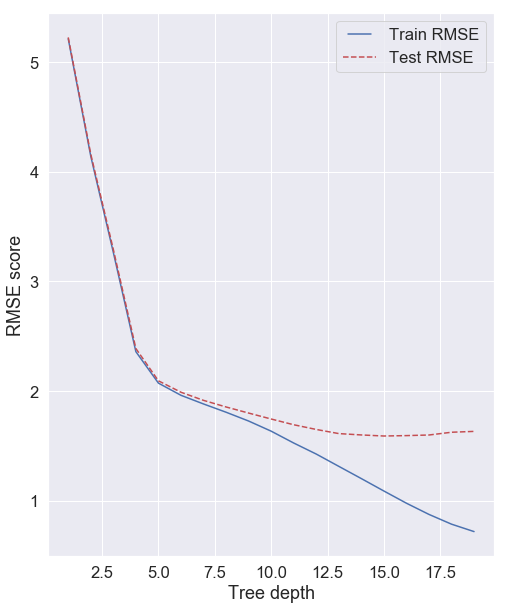

In [1985]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depth, train_results, 'b', label='Train RMSE')
line2, = plt.plot(max_depth, test_results, 'r--', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE score')
plt.xlabel('Tree depth')
plt.show()

Let's choose 15 as max depth

In [1986]:
dtree = DecisionTreeRegressor(max_depth=15)

dtree.fit(X_trainu, y_trainu)

train_pred = dtree.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(DecisionTreeRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train score : 1.0880395376247955
Test score : 1.5833659232297672


In [1987]:
train_cv = cross_val_score(DecisionTreeRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(DecisionTreeRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

dt_reg_uber = {}
dt_reg_uber['Train'] = round(train_rmse, 4)
dt_reg_uber['Test'] = round(test_rmse, 4)
dt_reg_uber

{'Train': 1.7006, 'Test': 1.9661}

**Lyft**

In [1989]:
X_trainl, X_testl, y_trainl, y_testl = train_test_split(lyft_leX, lyft_ley, test_size=0.3, random_state=42)

In [1990]:
dtree = DecisionTreeRegressor(max_depth=15)

dtree.fit(X_trainl, y_trainl)

train_pred = dtree.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(DecisionTreeRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1)

Train score : 1.6505630957136392
Test score : 2.664406721933393


In [1991]:
train_cv = cross_val_score(DecisionTreeRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(DecisionTreeRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

dt_reg_lyft = {}
dt_reg_lyft['Train'] = round(train_rmse, 4)
dt_reg_lyft['Test'] = round(test_rmse, 4)
dt_reg_lyft

{'Train': 2.9829, 'Test': 3.3157}

**HyperParameter tuning**

In [ ]:
param_grid = {'max_depth': np.arange(3, 30),
             'min_samples_split': np.arange(.1,1.1,.1),
             'min_samples_leaf': np.arange(.1,.6,.1)}

In [ ]:
grid_srch_dtree = tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10,scoring='neg_mean_squared_error')
grid_srch_dtree.fit(X_trainu, y_trainu)
grid_srch_dtree.best_estimator_

### 6. Random Forest

In [174]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.cross

In [1992]:
rf = RandomForestRegressor()
rf.fit(X_trainu, y_trainu)

train_pred = rf.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = rf.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(RandomForestRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

C:\Users\gokul\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train score : 0.7409353223082231
Test score : 1.393091910916908
[1.44005863 1.4471492  1.40270669 1.45192368 1.37614436]


In [1993]:
train_cv = cross_val_score(RandomForestRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(RandomForestRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

rf_reg_uber = {}
rf_reg_uber['Train'] = round(train_rmse, 4)
rf_reg_uber['Test'] = round(test_rmse, 4)
rf_reg_uber

{'Train': 1.423, 'Test': 1.5769}

**Hyper Parameter Tuning**

In [ ]:
param_grid = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
              'max_features' : list(range(1,X_trainu.shape[1])),
              'max_depth': np.arange(3, 30),
             'min_samples_split': np.arange(.1,1.1,.1),
             'min_samples_leaf': np.arange(.1,.6,.1)}

In [ ]:
grid_srch_rf = tree = GridSearchCV(RandomForestRegressor(), param_grid, cv=10,scoring='neg_mean_squared_error')
grid_srch_rf.fit(X_trainu, y_trainu)
grid_srch_rf.best_estimator_

In [1994]:
rf = RandomForestRegressor()
rf.fit(X_trainl, y_trainl)

train_pred = rf.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = rf.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(RandomForestRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

C:\Users\gokul\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train score : 1.2099745056182545
Test score : 2.3693293589037077
[2.46153291 2.49284955 2.44848945 2.41190071 2.42680192]


In [1995]:
train_cv = cross_val_score(RandomForestRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(RandomForestRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

rf_reg_lyft = {}
rf_reg_lyft['Train'] = round(train_rmse, 4)
rf_reg_lyft['Test'] = round(test_rmse, 4)
rf_reg_lyft

{'Train': 2.4492, 'Test': 2.6183}

### 7. Boosting

**Ada Boost**

In [178]:
from sklearn.ensemble import AdaBoostRegressor

In [1259]:
abr = AdaBoostRegressor(random_state=42)

abr.fit(X_trainu, y_trainu)

train_pred = abr.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = abr.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(AdaBoostRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 5.801814617682737
Test score : 5.818091938789842
[5.5122542  5.69288263 5.34465297 5.32064093 5.70734424]


In [1260]:
train_cv = cross_val_score(AdaBoostRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(AdaBoostRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

abr_reg_uber = {}
abr_reg_uber['Train'] = round(train_rmse, 4)
abr_reg_uber['Test'] = round(test_rmse, 4)
abr_reg_uber

{'Train': 5.5402, 'Test': 5.5358}

In [1261]:
abr = AdaBoostRegressor(random_state=42)

abr.fit(X_trainl, y_trainl)

train_pred = abr.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = abr.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(AdaBoostRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 5.950612179138436
Test score : 5.990572223255693
[5.93783734 6.12187474 6.80978001 6.68469601 6.58685351]


In [1262]:
train_cv = cross_val_score(AdaBoostRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(AdaBoostRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

abr_reg_lyft = {}
abr_reg_lyft['Train'] = round(train_rmse, 4)
abr_reg_lyft['Test'] = round(test_rmse, 4)
abr_reg_lyft

{'Train': 5.9007, 'Test': 5.5681}

**Gradient Boosting**

In [183]:
from sklearn.ensemble import GradientBoostingRegressor

**Uber**

In [1996]:
X_trainu.head()

,distance,destination,source,name,hour,pressure,rain
37054,0.99,4,5,4,16,1018.92000,0.0080
129011,1.25,5,4,5,9,1000.08000,0.0000
255934,1.41,10,6,3,14,991.75000,0.0000
164678,1.56,0,2,2,8,1001.11000,0.0000
79155,2.33,6,0,4,0,1006.03625,0.1569


In [1997]:
gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_trainu, y_trainu)

train_pred = gbr.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = gbr.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(GradientBoostingRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 1.8112309370045312
Test score : 1.8385149477069842
[1.85530173 1.84963684 1.77497461 1.83804905 1.74627353]


In [1998]:
train_cv = cross_val_score(GradientBoostingRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(GradientBoostingRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

gbr_reg_uber = {}
gbr_reg_uber['Train'] = round(train_rmse, 4)
gbr_reg_uber['Test'] = round(test_rmse, 4)
gbr_reg_uber

{'Train': 1.8128, 'Test': 1.8386}

**Lyft**

In [1999]:
gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_trainl, y_trainl)

train_pred = gbr.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = gbr.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(GradientBoostingRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 2.796350149743055
Test score : 2.809142078335918
[2.79864226 2.85381168 2.80264815 2.73051397 2.80779499]


In [2000]:
train_cv = cross_val_score(GradientBoostingRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(GradientBoostingRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

gbr_reg_lyft = {}
gbr_reg_lyft['Train'] = round(train_rmse, 4)
gbr_reg_lyft['Test'] = round(test_rmse, 4)
gbr_reg_lyft

{'Train': 2.7987, 'Test': 2.8128}

**Xg Boosting**

In [188]:
from xgboost import XGBRegressor

**Uber**

In [2001]:
xbr = XGBRegressor(random_state=42)

xbr.fit(X_trainu, y_trainu)

train_pred = xbr.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = xbr.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(XGBRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

C:\Users\gokul\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:06:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train score : 1.801719452924508
Test score : 1.8286004832407086
[1.8586963  1.84596709 1.76502341 1.83581353 1.75849327]


In [2002]:
train_cv = cross_val_score(XGBRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(XGBRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

xbr_reg_uber = {}
xbr_reg_uber['Train'] = round(train_rmse, 4)
xbr_reg_uber['Test'] = round(test_rmse, 4)
xbr_reg_uber

{'Train': 1.8128, 'Test': 1.8389}

**Lyft**

In [2003]:
xbr = XGBRegressor(random_state=42)

xbr.fit(X_trainl, y_trainl)

train_pred = xbr.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = xbr.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(XGBRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

C:\Users\gokul\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:07:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train score : 2.788957348869898
Test score : 2.8034948574341185
[2.79595571 2.84916699 2.80231315 2.73141629 2.80647778]


In [2004]:
train_cv = cross_val_score(XGBRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(XGBRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

xbr_reg_lyft = {}
xbr_reg_lyft['Train'] = round(train_rmse, 4)
xbr_reg_lyft['Test'] = round(test_rmse, 4)
xbr_reg_lyft

{'Train': 2.7971, 'Test': 2.8139}

**Cat Boost**

Cat boost was designed to handle categorical values in the data automatically, it prevents overfitting, and has less prediction 
time, because it builds symmetric trees.

In [193]:
from catboost import CatBoostRegressor

**Uber**

In [ ]:
X = uber_data.drop(['surge_multiplier', 'price', 'humidity', 'clouds', 'temp', 'wind'], axis=1)
y = uber_data['price'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features_indices = np.where(X.dtypes != np.number)[0]
categorical_features_indices

In [ ]:
model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE', verbose=400)
model.fit(X_train, y_train,cat_features=[1,2,3,4],eval_set=(X_test, y_test),plot=True)

In [ ]:
train_cv = cross_val_score(CatBoostRegressor(), X_train, y_train, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(CatBoostRegressor(), X_test, y_test, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

cbr_reg_uber = {}
cbr_reg_uber['Train'] = round(train_rmse, 4)
cbr_reg_uber['Test'] = round(test_rmse, 4)
cbr_reg_uber

**Lyft**

In [ ]:
X = lyft_data.drop(['surge_multiplier', 'price', 'humidity', 'clouds', 'temp', 'wind'], axis=1)
y = lyft_data['price'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features_indices = np.where(X.dtypes != np.number)[0]
categorical_features_indices

In [ ]:
model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=[1,2,3,4],eval_set=(X_test, y_test),plot=True)

In [ ]:
train_cv = cross_val_score(CatBoostRegressor(), X_train, y_train, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(CatBoostRegressor(), X_test, y_test, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

xbr_reg_lyft = {}
xbr_reg_lyft['Train'] = round(train_rmse, 4)
xbr_reg_lyft['Test'] = round(test_rmse, 4)
xbr_reg_lyft

**Uber results**

## RMSE

In [2010]:
final_results = pd.DataFrame([l_reg_uber, r_reg_uber, la_reg_uber, el_reg_uber, dt_reg_uber,
                              rf_reg_uber, abr_reg_uber, gbr_reg_uber, xbr_reg_uber, cbr_reg_uber],
                            index=['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net Regression',
                                  'Decision Tree', 'Random Forest', 'Ada Boost', 'Gradient Boost', 'Xg Boost',
                                  'Cat Boost'])
final_results

,Train,Test
Linear Regression,2.3612,2.3783
Ridge Regression,2.3611,2.3783
Lasso Regression,5.4642,5.4697
Elastic Net Regression,6.9598,6.9721
Decision Tree,1.7006,1.9661
Random Forest,1.4230,1.5769
Ada Boost,5.5402,5.5358
Gradient Boost,1.8128,1.8386
Xg Boost,1.8128,1.8389
Cat Boost,1.5113,1.5421


**Lyft results**

## RMSE

In [2011]:
final_results = pd.DataFrame([l_reg_lyft, r_reg_lyft, la_reg_lyft, el_reg_lyft, dt_reg_lyft,
                              rf_reg_lyft, abr_reg_lyft, gbr_reg_lyft, xbr_reg_lyft, cbr_reg_lyft],
                            index=['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net Regression',
                                  'Decision Tree', 'Random Forest', 'Ada Boost', 'Gradient Boost', 'Xg Boost',
                                  'Cat Boost'])
final_results

,Train,Test
Linear Regression,3.4087,3.4084
Ridge Regression,3.4087,3.4084
Lasso Regression,6.1500,6.1492
Elastic Net Regression,8.0544,8.0569
Decision Tree,2.9829,3.3157
Random Forest,2.4492,2.6183
Ada Boost,5.9007,5.5681
Gradient Boost,2.7987,2.8128
Xg Boost,2.7971,2.8139
Cat Boost,2.3137,2.3504
